In [3]:
import json
import os 
import numpy as np
import open3d as op3
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import pandas as pd
from sklearn.cluster import DBSCAN
plt.rcParams["font.family"] = "Times New Roman"
from open3d.web_visualizer import draw
# from PY.VisulizerTools import *

In [4]:
theta = np.sort(np.array([[-25,1.4],[-1,-4.2],[-1.667,1.4],[-15.639,-1.4],
                            [-11.31,1.4],[0,-1.4],[-0.667,4.2],[-8.843,-1.4],
                            [-7.254,1.4],[0.333,-4.2],[-0.333,1.4],[-6.148,-1.4],
                            [-5.333,4.2],[1.333,-1.4],[0.667,4.2],[-4,-1.4],
                            [-4.667,1.4],[1.667,-4.2],[1,1.4],[-3.667,-4.2],
                            [-3.333,4.2],[3.333,-1.4],[2.333,1.4],[-2.667,-1.4],
                            [-3,1.4],[7,-1.4],[4.667,1.4],[-2.333,-4.2],
                            [-2,4.2],[15,-1.4],[10.333,1.4],[-1.333,-1.4]
                            ])[:,0])
azimuths = np.arange(0,360,0.2)

In [24]:
# ann_path = './Vateran Filtered/ds0/ann'
ann_path = './Veteran_Filtered_1117/ds0/ann'
ann_names = os.listdir(ann_path)
pcd_path = '../../Lidar-Tracker/RawLidarData/Veteran/OutputFile/OutputPcd/'
pcd_list = os.listdir(pcd_path)
azi_las_info_path = '../../Lidar-Tracker/RawLidarData/Veteran/OutputFile/OutputAzimuthLaserInfo'
az_names = os.listdir(azi_las_info_path)

In [25]:
Frames = []
Point_inds = []
Classes = []
Azimuth_chanels = []
Laser_ids = []
Distances = []
Labeling_maps = []
Frame_inds_for_td = []
for i in range(len(ann_names)):
    with open(os.path.join(ann_path,ann_names[i])) as f:
        data = json.load(f)
    if len(data['figures']) == 0:
        continue
        
    azla_info = np.load(os.path.join(azi_las_info_path,az_names[i]))
    Labeling_map = -1*np.ones((32,1800))
    for ind in range(len(data['figures'])):
        class_key = data['figures'][ind]['objectKey']
        for j in range(len(data['objects'])):
            if class_key == data['objects'][j]['key']:
                Classes.append(data['objects'][j]['classTitle'])
                break
        
        Point_ind = data['figures'][ind]['geometry']['indices']
        Point_inds.append(Point_ind)
        Frames.append(int(ann_names[i][:6]))
        Labeling_map[azla_info[Point_ind,0].astype('int'),azla_info[Point_ind,1].astype('int')] = ind
        Azimuth_chanels.append(azla_info[Point_ind,1].astype('int'))
        Laser_ids.append(azla_info[Point_ind,0].astype('int'))
        Distances.append(azla_info[Point_ind,2])
    Labeling_maps.append(Labeling_map)
    Frame_inds_for_td.append(int(ann_names[i][:6]))
        
Frames = np.array(Frames)
Classes = np.array(Classes)
Xs,Ys,Zs = [],[],[]
for i in range(len(Classes)):
    longitudes = theta[Laser_ids[i]] * np.pi / 180
    latitudes = azimuths[Azimuth_chanels[i]] * np.pi / 180
    hypotenuses = Distances[i] * np.cos(longitudes)
    X = hypotenuses * np.sin(latitudes)
    Y = hypotenuses * np.cos(latitudes)
    Z = Distances[i] * np.sin(longitudes)
    Xs.append(X)
    Ys.append(Y)
    Zs.append(Z)
    

In [29]:
mean_dis_instance = []
point_num_instance = []
for d in Distances:
    mean_dis_instance.append(np.mean(d))
    point_num_instance.append(len(d))

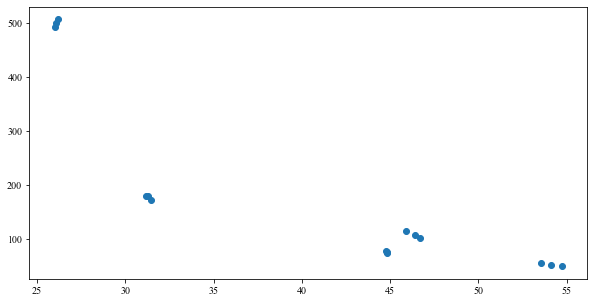

In [30]:
plt.figure(figsize=(10,5))
plt.scatter(mean_dis_instance,point_num_instance,)
plt.show()

In [6]:
from PY.BfTableGenerator import RansacCollector
from PY.DDBSCAN import Raster_DBSCAN

In [13]:
pcap_path = '../../Lidar-Tracker/RawLidarData/Veteran/Veteran.pcap'
# output_file_path = '../../Lidar-Tracker/RawLidarData/Veteran'
# background_update_frame = 2000
collector = RansacCollector(pcap_path,update_frame_num = 17950)
collector.gen_tdmap()
collector.gen_thredmap(d = 1.2,thred_s = 0.3,N = 20,delta_thred = 1e-3,step = 0.1)

Loading pcap...


100%|████████████████████████████████████████████████████████████████████████████| 17950/17950 [17:05<00:00, 17.50it/s]


Generating Threshold Map


## TP: target point, BCK: background point, GT: ground truth, RT: result 

In [31]:
def get_single_frame_metric_tp(Ground_thruth,Result): 
    ong_tp = ((Result != -1) & (Ground_thruth != -1)).sum()
    o_tp = (Result !=-1).sum()
    g_tp = (Ground_thruth != -1).sum()
    oog_tp = ((Result != -1) | (Ground_thruth != -1)).sum()
    return ong_tp,o_tp,g_tp,oog_tp


In [32]:
def get_single_frame_metric_bck(Ground_thruth,Result): 
    ong_bck = ((Result == -1) & (Ground_thruth == -1)).sum()
    o_bck = (Result == -1).sum()
    g_bck = (Ground_thruth == -1).sum()
    oog_bck = ((Result == -1) | (Ground_thruth == -1)).sum()
    return ong_bck,o_bck,g_bck,oog_bck


In [33]:
def get_overall_IOU(Ground_thruth,Result):
    Ground_thruth = Ground_thruth.copy()
    Result = Result.copy()
    a = ((Ground_thruth != -1) & (Result != -1)).sum()
    b = ((Ground_thruth != -1) | (Result != -1)).sum()
    if b == 0:
        return 0
    else:
        return a / b
     

In [34]:
def get_single_frame_metric_tp_instance(Ground_thruth,Result): 
    ids_rt = np.unique(Result)
    ids_rt = ids_rt[ids_rt != -1].astype('int')

    ids_gt = np.unique(Ground_thruth)
    ids_gt = ids_gt[ids_gt != -1].astype('int')
    IOUs = np.zeros((ids_rt.shape[0],ids_gt.shape[0]))
    for i,label_rt in enumerate(ids_rt):
        for j,label_gt in enumerate(ids_gt):
            temp_gt = Ground_thruth.copy()
            temp_rt = Result.copy()
            temp_gt[temp_gt!=label_gt] = int(-1)
            temp_rt[temp_rt!=label_rt] = int(-1)
            IOUs[i,j] = get_overall_IOU(temp_gt,temp_rt)
    ong_tps = []
    oog_tps = []
    o_tps = []
    g_tps = []

    
    for i,rt_ind in enumerate(ids_rt):
        if IOUs[i].max() != 0:
            temp_gt = Ground_thruth.copy()
            temp_rt = Result.copy()
            gt_ind = IOUs[i].argmax()
            ong_tp = ((temp_gt == ids_gt[gt_ind]) & (temp_rt == rt_ind)).sum()
            oog_tp = ((temp_gt == ids_gt[gt_ind]) | (temp_rt == rt_ind)).sum()
            ong_tps.append(ong_tp)
            oog_tps.append(oog_tp)
            o_tps.append((temp_rt == rt_ind).sum())
            g_tps.append((temp_gt == ids_gt[gt_ind]).sum())

    o_tps = np.sum(o_tps)
    g_tps = np.sum(g_tps)
    ong_tps = np.sum(ong_tps)
#     oog_tps = np.sum(oog_tps)
    oog_tps = ((Ground_thruth != -1) | (Result != -1)).sum()

    return ong_tps,o_tps,g_tps,oog_tps

In [35]:
def get_single_frame_instance_num(Ground_thruth,Result,IOU_thred): 
    ids_rt = np.unique(Result)
    ids_rt = ids_rt[ids_rt != -1].astype('int')
    ids_gt = np.unique(Ground_thruth)
    ids_gt = ids_gt[ids_gt != -1].astype('int')
    IOUs = np.zeros((ids_rt.shape[0],ids_gt.shape[0]))
    num_gt = len(ids_gt)
    for i,label_rt in enumerate(ids_rt):
        for j,label_gt in enumerate(ids_gt):
            temp_gt = Ground_thruth.copy()
            temp_rt = Result.copy()
            temp_gt[temp_gt!=label_gt] = int(-1)
            temp_rt[temp_rt!=label_rt] = int(-1)
            IOUs[i,j] = get_overall_IOU(temp_gt,temp_rt)
    num_rt = 0
    for i,rt_ind in enumerate(ids_rt):
        if IOUs[i].max() != 0:
            num_rt += 1
    return num_gt,num_rt

In [36]:
window_size=(5,13)
eps=1.8
min_samples=20
f_ind = 0
db = Raster_DBSCAN(window_size=window_size, eps=eps,min_samples=min_samples, Td_map_szie=(32,1800))
Foreground_map=(collector.aggregated_map[f_ind]!=0)&(collector.aggregated_map[f_ind] < collector.thred_map)
Labeling_map = db.fit_predict(collector.aggregated_map[f_ind],Foreground_map=Foreground_map)
Td_map = collector.aggregated_map[f_ind]
pcd = get_pcd_colored(Td_map,Labeling_map)

In [37]:
Ground_thruth = Labeling_maps[0].astype('int')

In [38]:
pcd = get_pcd_colored(Td_map,Ground_thruth)

In [39]:
draw(pcd)

WebVisualizer(window_uid='window_0')

In [40]:
def get_metric_fstcd(window_size,eps,min_samples):
    db = Raster_DBSCAN(window_size=window_size, eps=eps,min_samples=min_samples, Td_map_szie=(32,1800))
    time_consumption = []
    ong_tps,o_tps,g_tps,oog_tps = [],[],[],[]
    ong_bcks,o_bcks,g_bcks,oog_bcks = [],[],[],[]
#     ong_tps_ins,o_tps_ins,g_tps_ins,oog_tps_ins = [],[],[],[]

    for i,f_ind in enumerate(Frame_inds_for_td):
        Foreground_map=(collector.aggregated_map[f_ind]!=0)&(collector.aggregated_map[f_ind] < collector.thred_map)
        b = time.process_time()
        Result = db.fit_predict(collector.aggregated_map[f_ind],Foreground_map=Foreground_map)
        a = time.process_time()
        Ground_thruth = Labeling_maps[i]
        ong_tp,o_tp,g_tp,oog_tp = get_single_frame_metric_tp(Ground_thruth,Result)
        ong_bck,o_bck,g_bck,oog_bck = get_single_frame_metric_bck(Ground_thruth,Result)
        num_gt,num_rt = get_single_frame_instance_num(Ground_thruth,Result,0.5)

        ong_tps.append(ong_tp)
        o_tps.append(o_tp)
        g_tps.append(g_tp)
        oog_tps.append(oog_tp)
        ong_bcks.append(ong_bck)
        o_bcks.append(o_bck)
        g_bcks.append(g_bck)
        oog_bcks.append(oog_bck)
        
#         ong_tps_ins.append(ong_tp_ins)
        
#         o_tps_ins.append(o_tp_ins)
#         g_tps_ins.append(g_tp_ins)
#         oog_tps_ins.append(oog_tp_ins)
        
        time_consumption.append((a - b)*1000)
        

    precision_tp = np.sum(ong_tps)/np.sum(o_tps)
    recall_tp = np.sum(ong_tps)/np.sum(g_tps)
    IoU_tp = np.sum(ong_tps)/np.sum(oog_tps)
    precision_bck = np.sum(ong_bcks)/np.sum(o_bcks)
    recall_bck = np.sum(ong_bcks)/np.sum(g_bcks)
    IoU_bck = np.sum(ong_bcks)/np.sum(oog_bcks)

#     precision_tp_ins = np.sum(ong_tps_ins)/np.sum(o_tps_ins)
#     recall_tp_ins = np.sum(ong_tps_ins)/np.sum(g_tps_ins)
#     IoU_tp_ins = np.sum(ong_tps_ins)/np.sum(oog_tps_ins)
    
    return precision_tp,recall_tp,IoU_tp,precision_bck,recall_bck,IoU_bck,np.mean(time_consumption),np.std(time_consumption)

In [41]:
# %%timeit
window_size=(5,13)
eps=1.8
min_samples=20
precision_tp,recall_tp,IoU_tp,precision_bck,recall_bck,IoU_bck,time_consumption_mean,time_consumption_std = get_metric_fstcd(window_size,eps,min_samples)

In [292]:
result_dic_fsctd = []
for height in tqdm([3,5,7,9,11,13]):
    for width in [7,9,11,13,15,17,19,23,27]:
        for min_samples in [10,15,20,25,30]:
            for eps in [0.5,0.8,1.0,1.2,1.5,1.8]:
                precision_tp,recall_tp,IoU_tp,precision_bck,recall_bck,IoU_bck,precision_tp_ins,recall_tp_ins,IoU_tp_ins,time_consumption_mean,time_consumption_std = get_metric_fstcd((height,width),eps,min_samples)
                result_dic_fsctd.append([height,width,min_samples,eps]+[precision_tp,recall_tp,IoU_tp,precision_bck,recall_bck,IoU_bck,precision_tp_ins,recall_tp_ins,IoU_tp_ins,time_consumption_mean,time_consumption_std])








  0%|                                                                                            | 0/6 [00:00<?, ?it/s]C:\Users\czh\anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in long_scalars
C:\Users\czh\anaconda3\lib\site-packages\ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\czh\anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars






 17%|█████████████▎                                                                  | 1/6 [48:34<4:02:54, 2914.96s/it]





 33%|██████████████████████████                                                    | 2/6 [1:56:22<3:37:22, 3260.73s/it]





 50%|███████████████████████████████████████                                       | 3/6 [3:19:57<3:09:20, 3786.99s/it]





 67%|████████████████████████████████████████████████████                          | 4/6 [4:51:34<2:23:19, 4299.88s

In [33]:

def get_instance_error_fstcd(window_size,eps,min_samples,IoU_thred):
    db = Raster_DBSCAN(window_size=window_size, eps=eps,min_samples=min_samples, Td_map_szie=(32,1800))
    num_gts = []
    num_rts = []
    for i,f_ind in enumerate(Frame_inds_for_td):
        Foreground_map=(collector.aggregated_map[f_ind]!=0)&(collector.aggregated_map[f_ind] < collector.thred_map)
        b = time.process_time()
        Result = db.fit_predict(collector.aggregated_map[f_ind],Foreground_map=Foreground_map)
        a = time.time()
        Ground_thruth = Labeling_maps[i]
        num_gt,num_rt = get_single_frame_instance_num(Ground_thruth,Result,IoU_thred)
        num_gts.append(num_gt)
        num_rts.append(num_rt)
    return num_gts,num_rts

In [34]:
window_size=(5,11)
eps=1.8
min_samples=15
IoU_thred = 0.5

num_gts,num_rts = get_instance_error_fstcd(window_size,eps,min_samples,IoU_thred)

In [49]:
def get_instance_error_dbscan(eps,min_samples,IoU_thred):
    db = DBSCAN(eps,min_samples,n_jobs=-1)
    num_gts = []
    num_rts = []
    for i,f_ind in enumerate(Frame_inds_for_td):
        XYZ = np.asarray(op3.io.read_point_cloud(os.path.join(pcd_path,pcd_list[f_ind])).points)
        b = time.process_time()
        Result_XYZ = db.fit_predict(XYZ)
        a = time.process_time()
        Result = (-1*np.ones((32,1800))).astype('int')
        az_info = np.load(os.path.join(azi_las_info_path,az_names[f_ind]))
        Result[az_info[:,0].astype('int'),az_info[:,1].astype('int')] = Result_XYZ
        Ground_thruth = Labeling_maps[i]
        
        num_gt,num_rt = get_single_frame_instance_num(Ground_thruth,Result,IoU_thred)
        num_gts.append(num_gt)
        num_rts.append(num_rt)
        
    return num_gts,num_rts

In [50]:
eps=1.2
min_samples=15
IoU_thred = 0.5
num_gts,num_rts = get_instance_error_dbscan(eps,min_samples,IoU_thred)

In [293]:
pd.DataFrame(np.array(result_dic_fsctd),columns=['Win_Height','Win_width','Min_sample','Eps','precision_tp','recall_tp','IoU_tp','precision_bck','recall_bck','IoU_bck','precision_tp_ins','recall_tp_ins','IoU_tp_ins','time_consumption_mean','time_consumption_std']).to_csv(r'tuning_result_fsctd.csv')

In [22]:
def get_metric_dbscan(eps,min_samples):
    db = DBSCAN(eps,min_samples,n_jobs=-1)
    Foreground_points = []
    time_consumption = []
    ong_tps,o_tps,g_tps,oog_tps = [],[],[],[]
    ong_bcks,o_bcks,g_bcks,oog_bcks = [],[],[],[]
    ong_tps_ins,o_tps_ins,g_tps_ins,oog_tps_ins = [],[],[],[]
    for i,f_ind in enumerate(Frame_inds_for_td):
        XYZ = np.asarray(op3.io.read_point_cloud(os.path.join(pcd_path,pcd_list[f_ind])).points)
        b = time.process_time()
        Result_XYZ = db.fit_predict(XYZ)
        a = time.process_time()
        Result = (-1*np.ones((32,1800))).astype('int')
        az_info = np.load(os.path.join(azi_las_info_path,az_names[f_ind]))
        Result[az_info[:,0].astype('int'),az_info[:,1].astype('int')] = Result_XYZ
        Ground_thruth = Labeling_maps[i]
        ong_tp,o_tp,g_tp,oog_tp = get_single_frame_metric_tp(Ground_thruth,Result)
        ong_bck,o_bck,g_bck,oog_bck = get_single_frame_metric_bck(Ground_thruth,Result)
        ong_tp_ins,o_tp_ins,g_tp_ins,oog_tp_ins = get_single_frame_metric_tp_instance(Ground_thruth,Result)
        ong_tps.append(ong_tp)
        o_tps.append(o_tp)
        g_tps.append(g_tp)
        oog_tps.append(oog_tp)
        ong_bcks.append(ong_bck)
        o_bcks.append(o_bck)
        g_bcks.append(g_bck)
        oog_bcks.append(oog_bck)
        ong_tps_ins.append(ong_tp_ins)
        o_tps_ins.append(o_tp_ins)
        g_tps_ins.append(g_tp_ins)
        oog_tps_ins.append(oog_tp_ins)
        
        Foreground_points.append(len(Result_XYZ))
        time_consumption.append((a - b)*1000)
        
        
      
    precision_tp = np.sum(ong_tps)/np.sum(o_tps)
    recall_tp = np.sum(ong_tps)/np.sum(g_tps)
    IoU_tp = np.sum(ong_tps)/np.sum(oog_tps)
    precision_bck = np.sum(ong_bcks)/np.sum(o_bcks)
    recall_bck = np.sum(ong_bcks)/np.sum(g_bcks)
    IoU_bck = np.sum(ong_bcks)/np.sum(oog_bcks)
    precision_tp_ins = np.sum(ong_tps_ins)/np.sum(o_tps_ins)
    recall_tp_ins = np.sum(ong_tps_ins)/np.sum(g_tps_ins)
    IoU_tp_ins = np.sum(ong_tps_ins)/np.sum(oog_tps_ins)
    
    return precision_tp,recall_tp,IoU_tp,precision_bck,recall_bck,IoU_bck,precision_tp_ins,recall_tp_ins,IoU_tp_ins,np.mean(Foreground_points),np.mean(time_consumption),np.std(time_consumption)

In [624]:
result_dic_dbscan = []
for min_samples in tqdm([10,15,20,25,30]):
    for eps in [0.5,0.8,1.0,1.2,1.5,1.8,2,2.2,2.4,2.6,2.8,3]:
        precision_tp,recall_tp,IoU_tp,precision_bck,recall_bck,IoU_bck,precision_tp_ins,recall_tp_ins,IoU_tp_ins,Foreground_points,time_consumption_mean,time_consumption_std = get_metric_dbscan(eps,min_samples)
        result_dic_dbscan.append([min_samples,eps]+[precision_tp,recall_tp,IoU_tp,precision_bck,recall_bck,IoU_bck,precision_tp_ins,recall_tp_ins,IoU_tp_ins,Foreground_points,time_consumption_mean,time_consumption_std])



100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [41:17<00:00, 495.41s/it]


In [144]:
pd.DataFrame(np.array(result_dic_dbscan),columns=['Min_sample','Eps','precision_tp','recall_tp','IoU_tp','precision_bck','recall_bck','IoU_bck','precision_tp_ins','recall_tp_ins','IoU_tp_ins','Foreground_points','time_consumption_mean','time_consumption_std']).to_csv(r'tuning_result_dbscan.csv')

NameError: name 'result_dic_dbscan' is not defined

In [619]:
%%timeit
eps=1.5
min_samples=16
precision_tp,recall_tp,IoU_tp,precision_bck,recall_bck,IoU_bck,precision_tp_ins,recall_tp_ins,IoU_tp_ins,Foreground_points,time_consumption_mean,time_consumption_std = get_metric_dbscan(eps,min_samples)

40.4 s ± 832 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Failed Instance for DBSCAN

In [65]:
def get_differece_label(Ground_thruth,Result_db,Result_td,frame_id,sum_dic): 
    ids_rt_db = np.unique(Result_db)
    ids_rt_db = ids_rt_db[ids_rt_db != -1].astype('int')
    ids_rt_td = np.unique(Result_td)
    ids_rt_td = ids_rt_td[ids_rt_td != -1].astype('int')
    ids_gt = np.unique(Ground_thruth)
    ids_gt = ids_gt[ids_gt != -1].astype('int')
    IOUs_db = np.zeros((ids_rt_db.shape[0],ids_gt.shape[0])).T
    IOUs_td = np.zeros((ids_rt_td.shape[0],ids_gt.shape[0])).T
    sum_list = -np.ones((len(ids_gt),3)).astype('int')
    sum_list[:,0] = ids_gt
    for i,label_gt in enumerate(ids_gt):
        for j,label_rt in enumerate(ids_rt_db):
            temp_gt = Ground_thruth.copy()
            temp_rt = Result_db.copy()
            temp_gt[temp_gt!=label_gt] = int(-1)
            temp_rt[temp_rt!=label_rt] = int(-1)
            IOUs_db[i,j] = get_overall_IOU(temp_gt,temp_rt)
    for i,label_gt in enumerate(ids_gt):
        for j,label_rt in enumerate(ids_rt_td):
            temp_gt = Ground_thruth.copy()
            temp_rt = Result_td.copy()
            temp_gt[temp_gt!=label_gt] = int(-1)
            temp_rt[temp_rt!=label_rt] = int(-1)
            IOUs_td[i,j] = get_overall_IOU(temp_gt,temp_rt)  
    for i in range(IOUs_db.shape[0]):
        if np.max(IOUs_db[i]) != 0:
            sum_list[ids_gt[i],2] = ids_rt_db[np.argmax(IOUs_db[i])]
    for i in range(IOUs_td.shape[0]):
        if np.max(IOUs_td[i]) != 0:
            sum_list[ids_gt[i],1] = ids_rt_td[np.argmax(IOUs_td[i])]     
    sum_dic[frame_id] = sum_list # 

In [66]:
db_db = DBSCAN(eps,min_samples,n_jobs=-1)
db_td = Raster_DBSCAN(window_size=window_size, eps=eps,min_samples=min_samples, Td_map_szie=(32,1800))
sum_dic = {}
for i,f_ind in enumerate(Frame_inds_for_td):
    Ground_thruth = Labeling_maps[i]
    XYZ = np.asarray(op3.io.read_point_cloud(os.path.join(pcd_path,pcd_list[f_ind])).points)
    Result_XYZ = db_db.fit_predict(XYZ)
    Result_db = (-1*np.ones((32,1800))).astype('int')
    az_info = np.load(os.path.join(azi_las_info_path,az_names[f_ind]))
    Result_db[az_info[:,0].astype('int'),az_info[:,1].astype('int')] = Result_XYZ
    Foreground_map=(collector.aggregated_map[f_ind]!=0)&(collector.aggregated_map[f_ind] < collector.thred_map)
    Result_td = db_td.fit_predict(collector.aggregated_map[f_ind],Foreground_map=Foreground_map)
    get_differece_label(Ground_thruth,Result_db,Result_td,f_ind,sum_dic)

In [87]:
for key in sum_dic:
    temp = sum_dic[key]
    for i in range(temp.shape[0]):
        if (temp[i,1] == -1) & (temp[i,2] != -1):
            print(key,temp[i,1],temp[i,2])

329 -1 3
911 -1 6
932 -1 6
1416 -1 10


In [75]:
for key in sum_dic:
    temp = sum_dic[key]
    for i in range(temp.shape[0]):
        if (temp[i,1] != -1) & (temp[i,2] == -1):
            print(key,temp[i,1],temp[i,2])

77 4 -1
78 4 -1
79 4 -1
81 4 -1
84 4 -1
85 4 -1
88 4 -1
106 1 -1
301 2 -1
348 0 -1
350 0 -1
392 1 -1
411 0 -1
421 1 -1
951 8 -1
957 9 -1
958 3 -1
959 9 -1
968 8 -1
970 7 -1
1875 12 -1
1877 12 -1
1878 14 -1
1878 12 -1
1920 16 -1
1921 16 -1
1922 14 -1
2000 12 -1


In [81]:
eps=1.2
min_samples=15
IoU_thred = 0.5
db_db = DBSCAN(eps,min_samples,n_jobs=-1)
window_size=(5,11)
eps=1.8
min_samples=15
IoU_thred = 0.5
db_td = Raster_DBSCAN(window_size=window_size, eps=eps,min_samples=min_samples, Td_map_szie=(32,1800))


In [92]:
f_ind = 2000  
XYZ = np.asarray(op3.io.read_point_cloud(os.path.join(pcd_path,pcd_list[f_ind])).points)
Result_XYZ = db_db.fit_predict(XYZ)
Result_db = (-1*np.ones((32,1800))).astype('int')
az_info = np.load(os.path.join(azi_las_info_path,az_names[f_ind]))
Result_db[az_info[:,0].astype('int'),az_info[:,1].astype('int')] = Result_XYZ
Foreground_map=(collector.aggregated_map[f_ind]!=0)&(collector.aggregated_map[f_ind] < collector.thred_map)
Result_td = db_td.fit_predict(collector.aggregated_map[f_ind],Foreground_map=Foreground_map)

In [93]:
visualize_label(Result_db,collector.aggregated_map[f_ind])

In [94]:
visualize_label(Result_td,collector.aggregated_map[f_ind])

## backgound filtering tuning 

### accuracy

In [111]:
from sklearn.metrics import confusion_matrix

In [136]:
y_trues = []
y_preds = []
for i,f_ind in enumerate(Frame_inds_for_td):
    Ground_thruth = Labeling_maps[i].copy() # ground truth map
    Ground_thruth[Ground_thruth != -1] = 1
    Ground_thruth[Ground_thruth == -1] = 0
    Ground_thruth = Ground_thruth.astype('int')
#     az_info = np.load(os.path.join(azi_las_info_path,az_names[f_ind])) # filtered result
    Result = np.zeros((32,1800)).astype('int')
    az_info = np.load(os.path.join(azi_las_info_path,az_names[f_ind]))
    Result[az_info[:,0].astype('int'),az_info[:,1].astype('int')] = 1
    Result = Result.astype('int')
    y_true = Ground_thruth.flatten()
    y_pred = Result.flatten()
    y_trues.append(y_true)
    y_preds.append(y_pred)

## density

In [23]:
import numpy as np
import scipy.spatial as spatial

In [24]:
def cal_xyz_coords(las_ids,azi_ids,Td_map_gt):
    
    longitudes = theta[las_ids] * np.pi / 180
    latitudes = azimuths[azi_ids] * np.pi / 180
    hypotenuses = Td_map_gt[las_ids,azi_ids] * np.cos(longitudes)
    X = hypotenuses * np.sin(latitudes)
    Y = hypotenuses * np.cos(latitudes)
    Z = Td_map_gt[las_ids,azi_ids] * np.sin(longitudes)
    XYZ = np.concatenate([X.reshape(-1,1),Y.reshape(-1,1),Z.reshape(-1,1)],axis = 1)
    return XYZ

In [26]:
def cal_dis(las_ids,azi_ids,Td_map_gt):
    return Td_map_gt[las_ids,azi_ids]

## 3D

In [25]:
radius_list = [0.5,0.8,1,1.2,1.5,1.8,2,2.2,2.4,2.6,2.8,3]
obj_mean_radius = []
back_mean_radius = []
for i,f_ind in enumerate(Frame_inds_for_td):
    print(i)
    Foreground_map=(collector.aggregated_map[f_ind]!=0)&(collector.aggregated_map[f_ind] < collector.thred_map)
    Ground_thruth = Labeling_maps[i].copy() # ground truth map
    ids_gt = np.unique(Ground_thruth)
    Td_map_gt = collector.aggregated_map[f_ind]
    for ind in ids_gt:
        las_ids,azi_ids = np.where((Ground_thruth == ind)& Foreground_map)
        xyz_coords = cal_xyz_coords(las_ids,azi_ids,Td_map_gt)
        xyz_coords = xyz_coords[(xyz_coords != 0).all(axis = 1)]
        tree = spatial.KDTree(np.array(xyz_coords))
        mean_neigbors_num_radius = []
        for r in radius_list:
            neighbors = tree.query_ball_tree(tree, r)
            mean_neighbors = np.mean([len(n) for n in neighbors])
            mean_neigbors_num_radius.append(mean_neighbors)
        if ind != -1:
            obj_mean_radius.append(mean_neigbors_num_radius)
        else:
            back_mean_radius.append(mean_neigbors_num_radius)
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215


KeyboardInterrupt: 

In [29]:
len(xyz_coords)

705

In [32]:
radius_list = [0.5,0.8,1,1.2,1.5,1.8,2,2.2,2.4,2.6,2.8,3]
obj_mean_radius = []
back_mean_radius = []
for i,f_ind in enumerate(Frame_inds_for_td):
    print(i)
    Foreground_map=(collector.aggregated_map[f_ind]!=0)&(collector.aggregated_map[f_ind] < collector.thred_map)
    Ground_thruth = Labeling_maps[i].copy() # ground truth map
    ids_gt = np.unique(Ground_thruth)
    Td_map_gt = collector.aggregated_map[f_ind]
    for ind in ids_gt:
        las_ids,azi_ids = np.where((Ground_thruth == ind)& Foreground_map)
        dis = cal_dis(las_ids,azi_ids,Td_map_gt)
        dis = dis[dis!=0]
        tree = spatial.KDTree(dis.reshape(-1,1))
        mean_neigbors_num_radius = []
        for r in radius_list:
            neighbors = tree.query_ball_tree(tree, r)
            mean_neighbors = np.mean([len(n) for n in neighbors])
            mean_neigbors_num_radius.append(mean_neighbors)
        if ind != -1:
            obj_mean_radius.append(mean_neigbors_num_radius)
        else:
            back_mean_radius.append(mean_neigbors_num_radius)
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260


In [48]:
57600*(1.72+1.23)/100

1699.2

In [33]:
obj_mean_radius = np.array(obj_mean_radius)
back_mean_radius = np.array(back_mean_radius)


In [41]:
mea_obj = np.mean(obj_mean_radius,axis = 0)
mea_bck = np.mean(back_mean_radius,axis = 0)
std_obj = np.std(obj_mean_radius,axis = 0)
std_bck = np.std(back_mean_radius,axis = 0)
ci_obj = 1.96 * std_obj/mea_obj
ci_bck = 1.96 * std_bck/mea_bck

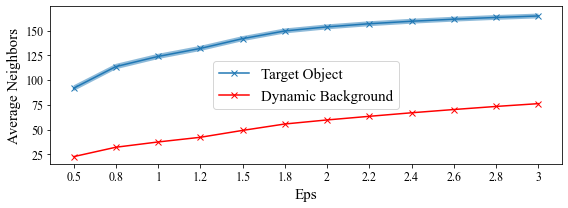

In [47]:
plt.figure(figsize=(8,3))
plt.plot(mea_obj,label = 'Target Object',marker = 'x')
plt.fill_between(np.arange(len(mea_obj)),(mea_obj - ci_obj),(mea_obj + ci_obj),alpha = .5)
plt.plot(mea_bck,label = 'Dynamic Background',marker = 'x',c = 'r')
plt.xticks(np.arange(len(radius_list)),radius_list,fontsize= 12)
plt.yticks(fontsize= 12)
plt.xlabel('Eps', fontsize=15)
plt.ylabel('Average Neighbors', fontsize=15)
plt.legend(fontsize=15)
plt.tight_layout()
# plt.savefig(r'E:\lidar\20210510 paper proj\AverageNeighbor.jpg',dpi = 300)
plt.show()

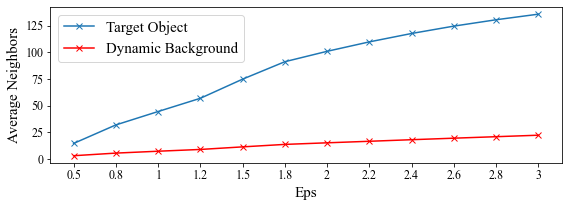

In [139]:
plt.figure(figsize=(8,3))

plt.plot(mea_obj,label = 'Target Object',marker = 'x')
plt.plot(mea_bck,label = 'Dynamic Background',marker = 'x',c = 'r')
plt.xticks(np.arange(len(radius_list)),radius_list,fontsize= 12)
plt.yticks(fontsize= 12)
plt.xlabel('Eps', fontsize=15)
plt.ylabel('Average Neighbors', fontsize=15)
plt.legend(fontsize=15)
plt.tight_layout()
plt.savefig(r'E:\lidar\20210510 paper proj\AverageNeighbor.jpg',dpi = 300)
plt.show()

## Detection Dis

In [4]:
def cal_xyz_coords_db(Foreground_map,Td_map):
    td_freq_map = Td_map
    Xs = []
    Ys = []
    Zs = []
    for i in range(td_freq_map.shape[0]):
        longitudes = theta[i] * np.pi / 180
        latitudes = azimuths[Foreground_map[i]] * np.pi / 180
        hypotenuses = td_freq_map[i][Foreground_map[i]] * np.cos(longitudes)
        X = hypotenuses * np.sin(latitudes)
        Y = hypotenuses * np.cos(latitudes)
        Z = td_freq_map[i][Foreground_map[i]] * np.sin(longitudes)
        Xs.append(X)
        Ys.append(Y)
        Zs.append(Z)
    Xs = np.concatenate(Xs).reshape(-1,1)
    Ys = np.concatenate(Ys).reshape(-1,1)
    Zs = np.concatenate(Zs).reshape(-1,1)
    XYZ = np.concatenate([Xs,Ys,Zs],axis = 1)
    
    return XYZ

In [5]:
def cal_xyz_coords_td(las_ids,azi_ids,Td_map_gt):
    
    longitudes = theta[las_ids] * np.pi / 180
    latitudes = azimuths[azi_ids] * np.pi / 180
    hypotenuses = Td_map_gt[las_ids,azi_ids] * np.cos(longitudes)
    X = hypotenuses * np.sin(latitudes)
    Y = hypotenuses * np.cos(latitudes)
    Z = Td_map_gt[las_ids,azi_ids] * np.sin(longitudes)
    XYZ = np.concatenate([X.reshape(-1,1),Y.reshape(-1,1),Z.reshape(-1,1)],axis = 1)
    
    return XYZ

In [6]:
from tqdm import tqdm_notebook
from BfTableGenerator import TDmapLoader
from BfTableGenerator import RansacCollector
from DDBSCAN import Raster_DBSCAN

In [7]:
collector = RansacCollector(pcap_path=r'E:\lidar\pcaps\RawLidarData\Vateran\Vateran.pcap',update_frame_num=17950)
lidar_reader = TDmapLoader(r'E:\lidar\pcaps\RawLidarData\Vateran\Vateran.pcap')
frame_gen = lidar_reader.frame_gen()
thred_map_list = []
aggregated_map_list = []
aggregated_maps = []

for i in tqdm_notebook(range(1,12000)):
    if i%2000 == 0:
        aggregated_maps = np.array(aggregated_maps)
        collector.aggregated_map  = aggregated_maps
        collector.gen_thredmap(d = 1.2,thred_s = 0.3,N = 20,delta_thred = 1e-3,step = 0.1)
        thred_map_list.append(collector.thred_map.copy())
        aggregated_map_list.append(aggregated_maps)
        aggregated_maps = []
        
    Td_map = next(frame_gen)
    aggregated_maps.append(Td_map)
    

C:\Users\czh\anaconda3\lib\site-packages\ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Generating Threshold Map
Generating Threshold Map
Generating Threshold Map
Generating Threshold Map
Generating Threshold Map



In [8]:
db_db = DBSCAN(eps = 1.5,min_samples = 15)
db_td = Raster_DBSCAN(window_size=(5,11), eps=1.8,min_samples=15, Td_map_szie=(32,1800))
object_coords_db = []
object_coords_td = []
objects_num_by_frame_td = []
objects_num_by_frame_db = []
fore_ground_points_by_frame = []
td_tc = []
db_tc = []
for i,aggregated_maps in enumerate(aggregated_map_list):
    
    thred_map = thred_map_list[i]
    for ind in tqdm_notebook(range(len(aggregated_maps))):
        Td_map = aggregated_maps[ind]
    
        Foreground_map=(Td_map!=0)&(Td_map < thred_map)

        XYZ = cal_xyz_coords_db(Foreground_map,Td_map)
        a = time.perf_counter()
        Labels_db = db_db.fit_predict(XYZ)
        db_tc.append((time.perf_counter() - a)*1000)
        a = time.perf_counter()
        Label_map_td = db_td.fit_predict(Td_map,Foreground_map=Foreground_map)
        td_tc.append((time.perf_counter() - a)*1000)

        unique_label_db,unique_label_td = np.unique(Labels_db),np.unique(Label_map_td)
        fore_ground_points_by_frame.append(Foreground_map.sum())
        objects_num_by_frame_td.append(len(unique_label_td) - 1)
        objects_num_by_frame_db.append(len(unique_label_db) - 1)

        for la in range(1,len(unique_label_db)):
            label = unique_label_db[la]
            object_coords_db.append(XYZ[Labels_db == label])
        for la in range(1,len(unique_label_td)):
            label = unique_label_td[la]
            las_ids,azi_ids = np.where(Label_map_td == label)
            object_coords_td.append(cal_xyz_coords_td(las_ids,azi_ids,Td_map))

C:\Users\czh\anaconda3\lib\site-packages\ipykernel_launcher.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  del sys.path[0]


C:\Users\czh\anaconda3\lib\site-packages\ipykernel_launcher.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  del sys.path[0]


C:\Users\czh\anaconda3\lib\site-packages\ipykernel_launcher.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  del sys.path[0]


C:\Users\czh\anaconda3\lib\site-packages\ipykernel_launcher.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  del sys.path[0]


C:\Users\czh\anaconda3\lib\site-packages\ipykernel_launcher.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  del sys.path[0]


In [9]:
mean_coord_db = np.array([o.mean(axis = 0) for o in object_coords_db])
mean_coord_td = np.array([o.mean(axis = 0) for o in object_coords_td])

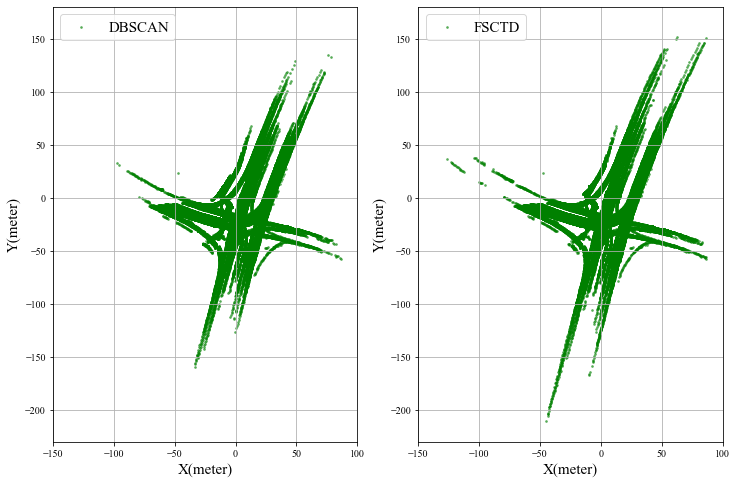

In [95]:
fig, axs = plt.subplots(1, 2,figsize=(12,8))
axs[0].grid()
axs[0].scatter(mean_coord_db[:,0],mean_coord_db[:,1],s = 3,label = 'DBSCAN',alpha = 0.5, c= 'g')
axs[0].set_xlabel('X(meter)',fontsize = 15)
axs[0].set_ylabel('Y(meter)',fontsize = 15)
axs[0].legend(fontsize = 15,loc = 'upper left')
axs[0].set_ylim(-230,180)
axs[0].set_xlim(-150,100)
# axs[0].legend(fontsize = 15)
axs[1].scatter(mean_coord_td[:,0],mean_coord_td[:,1],s = 3,label = 'FSCTD',alpha = 0.5, c= 'g')
axs[1].legend(fontsize = 15,loc = 'upper left')
axs[1].set_xlim(-150,100)
axs[1].set_ylim(-230,180)
axs[1].set_xlabel('X(meter)',fontsize = 15)
axs[1].set_ylabel('Y(meter)',fontsize = 15)
axs[1].grid()
plt.savefig(r'E:\lidar\FSCTD\Figs\7.tif',dpi = 900)
plt.show()

In [10]:
fore_ground_points_by_frame = np.array(fore_ground_points_by_frame)
td_tc = np.array(td_tc)
db_tc = np.array(db_tc)

In [34]:
from scipy.optimize import curve_fit

In [44]:
def func(x,b,c):
    return b*x*np.log(b*x) + c

In [45]:
curve_fit(func,fore_ground_points_by_frame,db_tc)

(array([ 1.51796944e-02, -1.24723039e+02]),
 array([[ 2.92701011e-09, -5.57594390e-05],
        [-5.57594390e-05,  2.35566298e+00]]))

In [32]:
np.polyfit(fore_ground_points_by_frame*np.log(fore_ground_points_by_frame),db_tc,1)

array([ 8.63186333e-03, -1.53992166e+02])

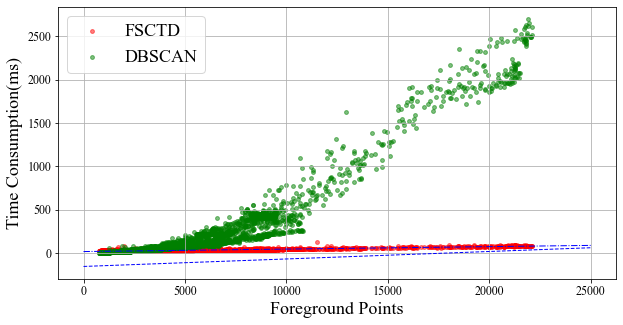

In [47]:
plt.figure(figsize=(10,5))
plt.scatter(fore_ground_points_by_frame,td_tc,s = 15, c = 'r',label = 'FSCTD',alpha = 0.5)
plt.scatter(fore_ground_points_by_frame,db_tc,s = 15, c = 'g',label = 'DBSCAN',alpha = 0.5)
x = np.arange(25000)
a,b,c = np.polyfit(fore_ground_points_by_frame,db_tc,2)
y_db = a*x**2 + b
a,b = np.polyfit(fore_ground_points_by_frame,td_tc,1)
y_td = a*x + b
plt.plot(x,y_db,c = 'b',linewidth = 1, linestyle = 'dashed')
plt.plot(x,y_td,c = 'b',linewidth = 1, linestyle = '-.')
plt.grid()
plt.ylabel('Time Consumption(ms)',fontsize = 18)
plt.xlabel('Foreground Points',fontsize = 18)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.legend(fontsize = 18)
# plt.savefig(r'E:\lidar\FSCTD\Figs\8.tif',dpi = 900)
plt.show()

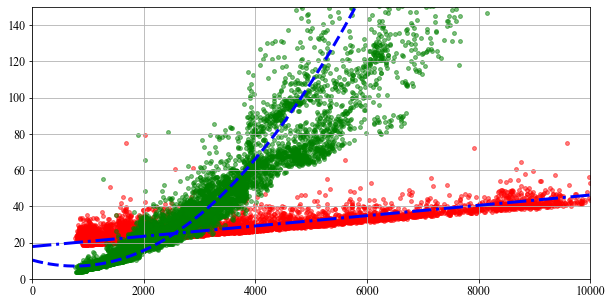

In [12]:
plt.figure(figsize=(10,5))
plt.scatter(fore_ground_points_by_frame,td_tc,s = 15, c = 'r',label = 'FSCTD',alpha = 0.5)
plt.scatter(fore_ground_points_by_frame,db_tc,s = 15, c = 'g',label = 'DBSCAN',alpha = 0.5)
x = np.arange(25000)
a,b,c = np.polyfit(fore_ground_points_by_frame,db_tc,2)
y_db = a*x**2 + b*x + c
a,b = np.polyfit(fore_ground_points_by_frame,td_tc,1)
y_td = a*x + b
plt.plot(x,y_db,c = 'b',linewidth = 3, linestyle = 'dashed')
plt.plot(x,y_td,c = 'b',linewidth = 3, linestyle = '-.')
plt.grid()
# plt.ylabel('Time Consumption(ms)',fontsize = 18)
# plt.xlabel('Foreground Points',fontsize = 18)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
# plt.legend(fontsize = 18)
plt.xlim(0,10000)
plt.ylim(0,150)
plt.savefig(r'E:\lidar\FSCTD\Figs\9.tif',dpi = 900)
plt.show()

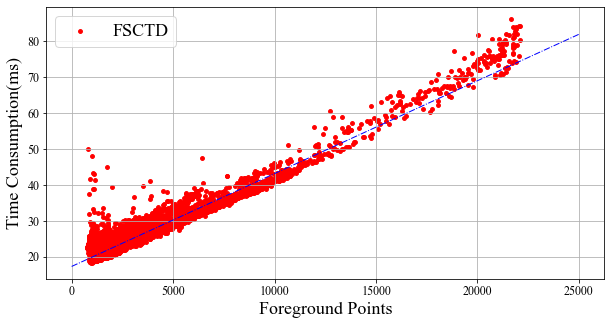

In [112]:
plt.figure(figsize=(10,5))
plt.scatter(fore_ground_points_by_frame,td_tc,s = 15, c = 'r',label = 'FSCTD')
x = np.arange(25000)
a,b = np.polyfit(fore_ground_points_by_frame,td_tc,1)
y_td = a*x + b
plt.plot(x,y_td,c = 'b',linewidth = 1, linestyle = '-.')
plt.grid()
plt.ylabel('Time Consumption(ms)',fontsize = 18)
plt.xlabel('Foreground Points',fontsize = 18)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.legend(fontsize = 18)
# plt.xlim(0,5000)
# plt.ylim(0,250)
plt.savefig(r'E:\lidar\FSCTD\Figs\10.tif',dpi = 900)
plt.show()

In [ ]:
fore_ground_points_by_frame

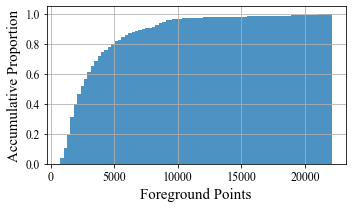

In [116]:
plt.figure(figsize=(5,3))
plt.grid()
plt.hist(fore_ground_points_by_frame,bins = 80,density=True,cumulative = True, alpha =0.8, )
plt.xlabel('Foreground Points',fontsize = 15)
plt.ylabel('Accumulative Proportion',fontsize = 15)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 11.5)
# plt.xlim(0,100)
plt.tight_layout()
plt.savefig(r'E:\lidar\FSCTD\Figs\11.tif',dpi = 900)
plt.show()

In [37]:
collector = RansacCollector(pcap_path=r'E:\lidar\pcaps\RawLidarData\Vateran\Vateran.pcap',update_frame_num=17950)
lidar_reader = TDmapLoader(r'E:\lidar\pcaps\RawLidarData\Vateran\Vateran.pcap')
frame_gen = lidar_reader.frame_gen()
aggregated_maps = np.array([next(frame_gen) for i in range(2000)])
collector.aggregated_map = aggregated_maps
collector.gen_thredmap(d = 1.2,thred_s = 0.3,N = 20,delta_thred = 1e-3,step = 0.1)

Generating Threshold Map


In [70]:
db_db = DBSCAN(eps = 1.5,min_samples = 15)
db_td = Raster_DBSCAN(window_size=(5,11), eps=1.8,min_samples=15, Td_map_szie=(32,1800))
object_coords_db = []
object_coords_td = []
objects_num_by_frame_td = []
objects_num_by_frame_db = []
fore_ground_points_by_frame = []
td_tc = []
db_tc = []
lidar_reader = TDmapLoader(r'E:\lidar\pcaps\RawLidarData\Vateran\Vateran.pcap')
frame_gen = lidar_reader.frame_gen()
aggregated_maps = []
for i in tqdm_notebook(range(1,17950)):
    if i%2000 == 0:
        aggregated_maps = np.array(aggregated_maps)
        collector.aggregated_map  = aggregated_maps
        collector.gen_thredmap(d = 1.2,thred_s = 0.3,N = 20,delta_thred = 1e-3,step = 0.1)
        aggregated_maps = []
        
    Td_map = next(frame_gen)
    aggregated_maps.append(Td_map)
    Foreground_map=(Td_map!=0)&(Td_map < collector.thred_map)
    
    XYZ = cal_xyz_coords_db(Foreground_map,Td_map)
    a = time.process_time()
    Labels_db = db_db.fit_predict(XYZ)
    db_tc.append((time.process_time() - a)*1000)
    a = time.process_time()
    Label_map_td = db_td.fit_predict(Td_map,Foreground_map=Foreground_map)
    td_tc.append((time.process_time() - a)*1000)
    
    unique_label_db,unique_label_td = np.unique(Labels_db),np.unique(Label_map_td)
    fore_ground_points_by_frame.append(Foreground_map.sum())
    objects_num_by_frame_td.append(len(unique_label_td) - 1)
    objects_num_by_frame_db.append(len(unique_label_db) - 1)
    
    for la in range(1,len(unique_label_db)):
        label = unique_label_db[la]
        object_coords_db.append(XYZ[Labels_db[label] == label])
    for la in range(1,len(unique_label_td)):
        label = unique_label_td[la]
        las_ids,azi_ids = np.where(Label_map_td == label)
        object_coords_td.append(cal_xyz_coords_td(las_ids,azi_ids,Td_map))
    

C:\Users\czh\anaconda3\lib\site-packages\ipykernel_launcher.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  del sys.path[0]


Generating Threshold Map
Generating Threshold Map
Generating Threshold Map
Generating Threshold Map
Generating Threshold Map
Generating Threshold Map
Generating Threshold Map
Generating Threshold Map



In [109]:
collector = RansacCollector(pcap_path=r'E:\lidar\pcaps\RawLidarData\Vateran\Vateran.pcap',update_frame_num=2000)
collector.gen_tdmap()
collector.gen_thredmap(d = 1.2,thred_s = 0.3,N = 20,delta_thred = 1e-3,step = 0.1)

  0%|                                                                                 | 2/2000 [00:00<01:40, 19.85it/s]

Loading pcap...


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:40<00:00, 19.94it/s]


Generating Threshold Map


In [111]:
# lidar_reader = TDmapLoader(r'E:\lidar\pcaps\RawLidarData\Vateran\Vateran.pcap')
# frame_gen = lidar_reader.frame_gen()
test = []
for i in tqdm_notebook(range(2000)):
    Td_map = collector.aggregated_map[i]
    Foreground_map=(Td_map!=0)&(Td_map < collector.thred_map)
    a = time.process_time()
    Label_map_td = db_td.fit_predict(Td_map,Foreground_map=Foreground_map)
    test.append((time.process_time() - a)*1000)

C:\Users\czh\anaconda3\lib\site-packages\ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [113]:
np.mean(test)

26.4921875

In [107]:
%%timeit
Label_map_td = db_td.fit_predict(Td_map,Foreground_map=Foreground_map)

31 ms ± 200 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [76]:
a = time.process_time()
Labels_db = db_db.fit_predict(XYZ)
(time.process_time() - a)*1000

109.375

In [72]:
np.mean(db_tc)

153.65236224859325

In [108]:
np.array(td_tc)

array([62.5  , 78.125, 62.5  , ..., 46.875, 46.875, 62.5  ])

In [74]:
np.mean(np.array(td_tc)[:20])

64.84375

 ## BF Time 

In [148]:
collector = RansacCollector(pcap_path=r'E:\lidar\pcaps\RawLidarData\Vateran\Vateran.pcap',update_frame_num=10000)
collector.gen_tdmap()






  0%|                                                                                        | 0/10000 [00:00<?, ?it/s]




  0%|                                                                                | 2/10000 [00:00<08:48, 18.92it/s]

Loading pcap...







  0%|                                                                                | 4/10000 [00:00<08:51, 18.81it/s]




  0%|                                                                                | 6/10000 [00:00<08:48, 18.90it/s]




  0%|                                                                                | 8/10000 [00:00<08:48, 18.90it/s]




  0%|                                                                               | 10/10000 [00:00<08:51, 18.80it/s]




  0%|                                                                               | 12/10000 [00:00<08:48, 18.89it/s]




  0%|                                                                               | 14/10000 [00:00<08:49, 18.84it/s]




  0%|▏                                                                              | 16/10000 [00:00<08:53, 18.71it/s]




  0%|▏                                                                              | 18/10000 [00:00<09:10, 18.12it/s]




  0

  2%|█▊                                                                            | 237/10000 [00:12<09:05, 17.91it/s]




  2%|█▊                                                                            | 239/10000 [00:13<08:50, 18.40it/s]




  2%|█▉                                                                            | 241/10000 [00:13<09:23, 17.31it/s]




  2%|█▉                                                                            | 243/10000 [00:13<10:13, 15.90it/s]




  2%|█▉                                                                            | 245/10000 [00:13<09:48, 16.59it/s]




  2%|█▉                                                                            | 247/10000 [00:13<09:34, 16.98it/s]




  2%|█▉                                                                            | 249/10000 [00:13<09:22, 17.34it/s]




  3%|█▉                                                                            | 251/10000 [00:13<09:19, 17.41it/s]




  3%|█▉ 

  5%|███▋                                                                          | 477/10000 [00:25<08:01, 19.79it/s]




  5%|███▋                                                                          | 479/10000 [00:25<08:00, 19.81it/s]




  5%|███▊                                                                          | 481/10000 [00:25<08:05, 19.59it/s]




  5%|███▊                                                                          | 483/10000 [00:25<08:06, 19.58it/s]




  5%|███▊                                                                          | 485/10000 [00:25<08:08, 19.49it/s]




  5%|███▊                                                                          | 487/10000 [00:25<08:09, 19.44it/s]




  5%|███▊                                                                          | 489/10000 [00:25<08:10, 19.39it/s]




  5%|███▊                                                                          | 491/10000 [00:26<08:09, 19.41it/s]




  5%|███

  7%|█████▌                                                                        | 711/10000 [00:37<07:56, 19.51it/s]




  7%|█████▌                                                                        | 713/10000 [00:37<07:56, 19.50it/s]




  7%|█████▌                                                                        | 715/10000 [00:37<07:57, 19.43it/s]




  7%|█████▌                                                                        | 717/10000 [00:37<07:56, 19.50it/s]




  7%|█████▌                                                                        | 719/10000 [00:37<07:54, 19.55it/s]




  7%|█████▌                                                                        | 721/10000 [00:37<07:52, 19.64it/s]




  7%|█████▋                                                                        | 723/10000 [00:37<07:50, 19.73it/s]




  7%|█████▋                                                                        | 725/10000 [00:38<07:50, 19.71it/s]




  7%|███

  9%|███████▍                                                                      | 949/10000 [00:49<07:45, 19.43it/s]




 10%|███████▍                                                                      | 951/10000 [00:49<07:45, 19.44it/s]




 10%|███████▍                                                                      | 953/10000 [00:49<07:44, 19.47it/s]




 10%|███████▍                                                                      | 955/10000 [00:49<07:43, 19.52it/s]




 10%|███████▍                                                                      | 957/10000 [00:49<07:45, 19.42it/s]




 10%|███████▍                                                                      | 959/10000 [00:50<07:45, 19.44it/s]




 10%|███████▍                                                                      | 961/10000 [00:50<07:47, 19.33it/s]




 10%|███████▌                                                                      | 963/10000 [00:50<07:45, 19.43it/s]




 10%|███

 12%|█████████▏                                                                   | 1191/10000 [01:01<07:34, 19.36it/s]




 12%|█████████▏                                                                   | 1193/10000 [01:01<07:34, 19.37it/s]




 12%|█████████▏                                                                   | 1195/10000 [01:02<07:33, 19.43it/s]




 12%|█████████▏                                                                   | 1197/10000 [01:02<07:31, 19.50it/s]




 12%|█████████▏                                                                   | 1199/10000 [01:02<07:30, 19.55it/s]




 12%|█████████▏                                                                   | 1201/10000 [01:02<07:28, 19.64it/s]




 12%|█████████▎                                                                   | 1203/10000 [01:02<07:26, 19.70it/s]




 12%|█████████▎                                                                   | 1205/10000 [01:02<07:27, 19.63it/s]




 12%|███

 14%|██████████▉                                                                  | 1424/10000 [01:13<07:13, 19.77it/s]




 14%|██████████▉                                                                  | 1426/10000 [01:13<07:13, 19.79it/s]




 14%|███████████                                                                  | 1429/10000 [01:14<07:10, 19.91it/s]




 14%|███████████                                                                  | 1432/10000 [01:14<07:09, 19.95it/s]




 14%|███████████                                                                  | 1434/10000 [01:14<07:11, 19.83it/s]




 14%|███████████                                                                  | 1436/10000 [01:14<07:11, 19.84it/s]




 14%|███████████                                                                  | 1438/10000 [01:14<07:11, 19.84it/s]




 14%|███████████                                                                  | 1440/10000 [01:14<07:12, 19.79it/s]




 14%|███

 17%|████████████▊                                                                | 1665/10000 [01:26<06:56, 19.99it/s]




 17%|████████████▊                                                                | 1667/10000 [01:26<06:57, 19.95it/s]




 17%|████████████▊                                                                | 1670/10000 [01:26<06:56, 20.02it/s]




 17%|████████████▉                                                                | 1673/10000 [01:26<06:56, 19.98it/s]




 17%|████████████▉                                                                | 1676/10000 [01:26<06:54, 20.08it/s]




 17%|████████████▉                                                                | 1679/10000 [01:26<06:52, 20.16it/s]




 17%|████████████▉                                                                | 1682/10000 [01:26<06:53, 20.13it/s]




 17%|████████████▉                                                                | 1685/10000 [01:27<06:54, 20.06it/s]




 17%|███

 19%|██████████████▋                                                              | 1914/10000 [01:38<07:01, 19.18it/s]




 19%|██████████████▊                                                              | 1916/10000 [01:38<06:59, 19.26it/s]




 19%|██████████████▊                                                              | 1918/10000 [01:39<07:02, 19.14it/s]




 19%|██████████████▊                                                              | 1920/10000 [01:39<06:59, 19.25it/s]




 19%|██████████████▊                                                              | 1922/10000 [01:39<07:01, 19.15it/s]




 19%|██████████████▊                                                              | 1924/10000 [01:39<07:02, 19.13it/s]




 19%|██████████████▊                                                              | 1926/10000 [01:39<06:59, 19.23it/s]




 19%|██████████████▊                                                              | 1928/10000 [01:39<06:58, 19.30it/s]




 19%|███

 22%|████████████████▌                                                            | 2151/10000 [01:51<06:45, 19.35it/s]




 22%|████████████████▌                                                            | 2153/10000 [01:51<06:44, 19.38it/s]




 22%|████████████████▌                                                            | 2155/10000 [01:51<06:45, 19.35it/s]




 22%|████████████████▌                                                            | 2157/10000 [01:51<06:46, 19.31it/s]




 22%|████████████████▌                                                            | 2159/10000 [01:51<06:44, 19.39it/s]




 22%|████████████████▋                                                            | 2161/10000 [01:51<06:44, 19.37it/s]




 22%|████████████████▋                                                            | 2163/10000 [01:51<06:44, 19.37it/s]




 22%|████████████████▋                                                            | 2165/10000 [01:51<06:43, 19.40it/s]




 22%|███

 24%|██████████████████▍                                                          | 2391/10000 [02:03<06:31, 19.44it/s]




 24%|██████████████████▍                                                          | 2393/10000 [02:03<06:31, 19.45it/s]




 24%|██████████████████▍                                                          | 2395/10000 [02:03<06:30, 19.46it/s]




 24%|██████████████████▍                                                          | 2397/10000 [02:03<06:29, 19.51it/s]




 24%|██████████████████▍                                                          | 2399/10000 [02:03<06:32, 19.39it/s]




 24%|██████████████████▍                                                          | 2401/10000 [02:03<06:38, 19.06it/s]




 24%|██████████████████▌                                                          | 2403/10000 [02:03<06:35, 19.21it/s]




 24%|██████████████████▌                                                          | 2405/10000 [02:03<06:31, 19.38it/s]




 24%|███

 26%|████████████████████▎                                                        | 2632/10000 [02:15<06:17, 19.50it/s]




 26%|████████████████████▎                                                        | 2634/10000 [02:15<06:17, 19.52it/s]




 26%|████████████████████▎                                                        | 2636/10000 [02:15<06:15, 19.62it/s]




 26%|████████████████████▎                                                        | 2638/10000 [02:16<06:14, 19.65it/s]




 26%|████████████████████▎                                                        | 2640/10000 [02:16<06:13, 19.71it/s]




 26%|████████████████████▎                                                        | 2642/10000 [02:16<06:13, 19.70it/s]




 26%|████████████████████▎                                                        | 2644/10000 [02:16<06:15, 19.60it/s]




 26%|████████████████████▎                                                        | 2646/10000 [02:16<06:14, 19.62it/s]




 26%|███

 29%|██████████████████████▏                                                      | 2875/10000 [02:28<06:04, 19.52it/s]




 29%|██████████████████████▏                                                      | 2877/10000 [02:28<06:06, 19.42it/s]




 29%|██████████████████████▏                                                      | 2879/10000 [02:28<06:07, 19.38it/s]




 29%|██████████████████████▏                                                      | 2881/10000 [02:28<06:08, 19.29it/s]




 29%|██████████████████████▏                                                      | 2883/10000 [02:28<06:12, 19.12it/s]




 29%|██████████████████████▏                                                      | 2885/10000 [02:28<06:11, 19.17it/s]




 29%|██████████████████████▏                                                      | 2887/10000 [02:28<06:12, 19.10it/s]




 29%|██████████████████████▏                                                      | 2889/10000 [02:28<06:08, 19.32it/s]




 29%|███

 31%|████████████████████████                                                     | 3128/10000 [02:41<05:53, 19.44it/s]




 31%|████████████████████████                                                     | 3130/10000 [02:41<05:54, 19.39it/s]




 31%|████████████████████████                                                     | 3132/10000 [02:41<05:52, 19.47it/s]




 31%|████████████████████████▏                                                    | 3134/10000 [02:41<05:51, 19.56it/s]




 31%|████████████████████████▏                                                    | 3136/10000 [02:41<05:50, 19.57it/s]




 31%|████████████████████████▏                                                    | 3138/10000 [02:41<05:51, 19.51it/s]




 31%|████████████████████████▏                                                    | 3140/10000 [02:41<05:51, 19.50it/s]




 31%|████████████████████████▏                                                    | 3142/10000 [02:42<05:49, 19.60it/s]




 31%|███

 34%|█████████████████████████▉                                                   | 3373/10000 [02:53<05:55, 18.65it/s]




 34%|█████████████████████████▉                                                   | 3375/10000 [02:53<05:52, 18.81it/s]




 34%|██████████████████████████                                                   | 3377/10000 [02:54<05:56, 18.58it/s]




 34%|██████████████████████████                                                   | 3379/10000 [02:54<06:00, 18.37it/s]




 34%|██████████████████████████                                                   | 3381/10000 [02:54<05:57, 18.53it/s]




 34%|██████████████████████████                                                   | 3383/10000 [02:54<05:52, 18.75it/s]




 34%|██████████████████████████                                                   | 3385/10000 [02:54<05:49, 18.91it/s]




 34%|██████████████████████████                                                   | 3387/10000 [02:54<05:49, 18.91it/s]




 34%|███

 36%|███████████████████████████▊                                                 | 3609/10000 [03:06<05:28, 19.48it/s]




 36%|███████████████████████████▊                                                 | 3612/10000 [03:06<05:24, 19.67it/s]




 36%|███████████████████████████▊                                                 | 3614/10000 [03:06<05:27, 19.50it/s]




 36%|███████████████████████████▊                                                 | 3616/10000 [03:06<05:28, 19.43it/s]




 36%|███████████████████████████▊                                                 | 3618/10000 [03:06<05:27, 19.50it/s]




 36%|███████████████████████████▊                                                 | 3620/10000 [03:06<05:29, 19.38it/s]




 36%|███████████████████████████▉                                                 | 3622/10000 [03:06<05:26, 19.52it/s]




 36%|███████████████████████████▉                                                 | 3624/10000 [03:07<05:25, 19.56it/s]




 36%|███

 38%|█████████████████████████████▌                                               | 3844/10000 [03:18<05:15, 19.48it/s]




 38%|█████████████████████████████▌                                               | 3846/10000 [03:18<05:16, 19.42it/s]




 38%|█████████████████████████████▋                                               | 3848/10000 [03:18<05:15, 19.49it/s]




 38%|█████████████████████████████▋                                               | 3850/10000 [03:18<05:16, 19.43it/s]




 39%|█████████████████████████████▋                                               | 3852/10000 [03:18<05:24, 18.94it/s]




 39%|█████████████████████████████▋                                               | 3854/10000 [03:18<05:23, 19.02it/s]




 39%|█████████████████████████████▋                                               | 3856/10000 [03:18<05:19, 19.26it/s]




 39%|█████████████████████████████▋                                               | 3858/10000 [03:19<05:19, 19.21it/s]




 39%|███

 41%|███████████████████████████████▍                                             | 4082/10000 [03:30<05:14, 18.82it/s]




 41%|███████████████████████████████▍                                             | 4084/10000 [03:30<05:14, 18.80it/s]




 41%|███████████████████████████████▍                                             | 4086/10000 [03:30<05:12, 18.94it/s]




 41%|███████████████████████████████▍                                             | 4088/10000 [03:30<05:08, 19.15it/s]




 41%|███████████████████████████████▍                                             | 4090/10000 [03:31<05:07, 19.24it/s]




 41%|███████████████████████████████▌                                             | 4092/10000 [03:31<05:04, 19.42it/s]




 41%|███████████████████████████████▌                                             | 4094/10000 [03:31<05:05, 19.32it/s]




 41%|███████████████████████████████▌                                             | 4096/10000 [03:31<05:09, 19.09it/s]




 41%|███

 43%|█████████████████████████████████▏                                           | 4316/10000 [03:42<04:51, 19.48it/s]




 43%|█████████████████████████████████▏                                           | 4318/10000 [03:42<04:52, 19.42it/s]




 43%|█████████████████████████████████▎                                           | 4320/10000 [03:42<04:52, 19.44it/s]




 43%|█████████████████████████████████▎                                           | 4322/10000 [03:43<04:50, 19.56it/s]




 43%|█████████████████████████████████▎                                           | 4324/10000 [03:43<04:51, 19.48it/s]




 43%|█████████████████████████████████▎                                           | 4326/10000 [03:43<04:51, 19.44it/s]




 43%|█████████████████████████████████▎                                           | 4328/10000 [03:43<04:52, 19.36it/s]




 43%|█████████████████████████████████▎                                           | 4330/10000 [03:43<04:51, 19.45it/s]




 43%|███

 45%|███████████████████████████████████                                          | 4549/10000 [03:54<04:39, 19.48it/s]




 46%|███████████████████████████████████                                          | 4551/10000 [03:54<04:39, 19.47it/s]




 46%|███████████████████████████████████                                          | 4553/10000 [03:54<04:40, 19.42it/s]




 46%|███████████████████████████████████                                          | 4555/10000 [03:55<04:39, 19.46it/s]




 46%|███████████████████████████████████                                          | 4557/10000 [03:55<04:40, 19.41it/s]




 46%|███████████████████████████████████                                          | 4559/10000 [03:55<04:40, 19.43it/s]




 46%|███████████████████████████████████                                          | 4561/10000 [03:55<04:40, 19.38it/s]




 46%|███████████████████████████████████▏                                         | 4563/10000 [03:55<04:40, 19.35it/s]




 46%|███

 48%|████████████████████████████████████▊                                        | 4782/10000 [04:06<04:29, 19.35it/s]




 48%|████████████████████████████████████▊                                        | 4784/10000 [04:06<04:27, 19.50it/s]




 48%|████████████████████████████████████▊                                        | 4786/10000 [04:06<04:27, 19.49it/s]




 48%|████████████████████████████████████▊                                        | 4788/10000 [04:07<04:29, 19.37it/s]




 48%|████████████████████████████████████▉                                        | 4790/10000 [04:07<04:27, 19.46it/s]




 48%|████████████████████████████████████▉                                        | 4792/10000 [04:07<04:26, 19.57it/s]




 48%|████████████████████████████████████▉                                        | 4794/10000 [04:07<04:27, 19.48it/s]




 48%|████████████████████████████████████▉                                        | 4796/10000 [04:07<04:27, 19.42it/s]




 48%|███

 50%|██████████████████████████████████████▊                                      | 5037/10000 [04:19<04:16, 19.37it/s]




 50%|██████████████████████████████████████▊                                      | 5039/10000 [04:19<04:16, 19.34it/s]




 50%|██████████████████████████████████████▊                                      | 5041/10000 [04:20<04:16, 19.37it/s]




 50%|██████████████████████████████████████▊                                      | 5043/10000 [04:20<04:16, 19.34it/s]




 50%|██████████████████████████████████████▊                                      | 5045/10000 [04:20<04:16, 19.35it/s]




 50%|██████████████████████████████████████▊                                      | 5047/10000 [04:20<04:15, 19.37it/s]




 50%|██████████████████████████████████████▉                                      | 5049/10000 [04:20<04:17, 19.26it/s]




 51%|██████████████████████████████████████▉                                      | 5051/10000 [04:20<04:15, 19.35it/s]




 51%|███

 53%|████████████████████████████████████████▌                                    | 5269/10000 [04:31<04:02, 19.48it/s]




 53%|████████████████████████████████████████▌                                    | 5271/10000 [04:31<04:04, 19.36it/s]




 53%|████████████████████████████████████████▌                                    | 5273/10000 [04:31<04:03, 19.39it/s]




 53%|████████████████████████████████████████▌                                    | 5275/10000 [04:32<04:03, 19.42it/s]




 53%|████████████████████████████████████████▋                                    | 5277/10000 [04:32<04:03, 19.38it/s]




 53%|████████████████████████████████████████▋                                    | 5279/10000 [04:32<04:04, 19.29it/s]




 53%|████████████████████████████████████████▋                                    | 5281/10000 [04:32<04:03, 19.40it/s]




 53%|████████████████████████████████████████▋                                    | 5283/10000 [04:32<04:04, 19.31it/s]




 53%|███

 55%|██████████████████████████████████████████▍                                  | 5504/10000 [04:43<03:50, 19.52it/s]




 55%|██████████████████████████████████████████▍                                  | 5506/10000 [04:44<03:52, 19.36it/s]




 55%|██████████████████████████████████████████▍                                  | 5508/10000 [04:44<03:51, 19.42it/s]




 55%|██████████████████████████████████████████▍                                  | 5510/10000 [04:44<03:50, 19.49it/s]




 55%|██████████████████████████████████████████▍                                  | 5512/10000 [04:44<03:51, 19.43it/s]




 55%|██████████████████████████████████████████▍                                  | 5514/10000 [04:44<03:50, 19.44it/s]




 55%|██████████████████████████████████████████▍                                  | 5516/10000 [04:44<03:51, 19.39it/s]




 55%|██████████████████████████████████████████▍                                  | 5518/10000 [04:44<03:49, 19.53it/s]




 55%|███

 58%|████████████████████████████████████████████▎                                | 5756/10000 [04:57<04:01, 17.60it/s]




 58%|████████████████████████████████████████████▎                                | 5758/10000 [04:57<03:59, 17.73it/s]




 58%|████████████████████████████████████████████▎                                | 5760/10000 [04:57<03:59, 17.69it/s]




 58%|████████████████████████████████████████████▎                                | 5762/10000 [04:57<03:58, 17.75it/s]




 58%|████████████████████████████████████████████▍                                | 5764/10000 [04:57<03:56, 17.89it/s]




 58%|████████████████████████████████████████████▍                                | 5766/10000 [04:57<03:54, 18.09it/s]




 58%|████████████████████████████████████████████▍                                | 5768/10000 [04:57<04:00, 17.61it/s]




 58%|████████████████████████████████████████████▍                                | 5770/10000 [04:57<04:02, 17.46it/s]




 58%|███

 60%|██████████████████████████████████████████████▏                              | 5999/10000 [05:10<03:59, 16.70it/s]




 60%|██████████████████████████████████████████████▏                              | 6001/10000 [05:10<03:54, 17.06it/s]




 60%|██████████████████████████████████████████████▏                              | 6003/10000 [05:11<03:44, 17.77it/s]




 60%|██████████████████████████████████████████████▏                              | 6006/10000 [05:11<03:36, 18.43it/s]




 60%|██████████████████████████████████████████████▎                              | 6009/10000 [05:11<03:30, 18.93it/s]




 60%|██████████████████████████████████████████████▎                              | 6011/10000 [05:11<03:29, 19.09it/s]




 60%|██████████████████████████████████████████████▎                              | 6013/10000 [05:11<03:27, 19.20it/s]




 60%|██████████████████████████████████████████████▎                              | 6015/10000 [05:11<03:25, 19.39it/s]




 60%|███

 62%|████████████████████████████████████████████████                             | 6240/10000 [05:24<03:33, 17.61it/s]




 62%|████████████████████████████████████████████████                             | 6242/10000 [05:25<03:36, 17.33it/s]




 62%|████████████████████████████████████████████████                             | 6244/10000 [05:25<03:31, 17.78it/s]




 62%|████████████████████████████████████████████████                             | 6246/10000 [05:25<03:25, 18.25it/s]




 62%|████████████████████████████████████████████████                             | 6248/10000 [05:25<03:20, 18.72it/s]




 63%|████████████████████████████████████████████████▏                            | 6251/10000 [05:25<03:15, 19.14it/s]




 63%|████████████████████████████████████████████████▏                            | 6253/10000 [05:25<03:21, 18.60it/s]




 63%|████████████████████████████████████████████████▏                            | 6255/10000 [05:25<03:19, 18.79it/s]




 63%|███

 65%|██████████████████████████████████████████████████                           | 6505/10000 [05:38<03:00, 19.38it/s]




 65%|██████████████████████████████████████████████████                           | 6508/10000 [05:38<02:57, 19.65it/s]




 65%|██████████████████████████████████████████████████▏                          | 6510/10000 [05:38<03:04, 18.93it/s]




 65%|██████████████████████████████████████████████████▏                          | 6512/10000 [05:38<03:04, 18.92it/s]




 65%|██████████████████████████████████████████████████▏                          | 6514/10000 [05:39<03:01, 19.19it/s]




 65%|██████████████████████████████████████████████████▏                          | 6516/10000 [05:39<03:02, 19.11it/s]




 65%|██████████████████████████████████████████████████▏                          | 6518/10000 [05:39<03:06, 18.68it/s]




 65%|██████████████████████████████████████████████████▏                          | 6520/10000 [05:39<03:03, 18.96it/s]




 65%|███

 68%|████████████████████████████████████████████████████▏                        | 6770/10000 [05:52<02:43, 19.76it/s]




 68%|████████████████████████████████████████████████████▏                        | 6772/10000 [05:52<02:46, 19.33it/s]




 68%|████████████████████████████████████████████████████▏                        | 6774/10000 [05:52<02:48, 19.15it/s]




 68%|████████████████████████████████████████████████████▏                        | 6776/10000 [05:52<02:50, 18.86it/s]




 68%|████████████████████████████████████████████████████▏                        | 6779/10000 [05:52<02:46, 19.35it/s]




 68%|████████████████████████████████████████████████████▏                        | 6781/10000 [05:52<02:47, 19.22it/s]




 68%|████████████████████████████████████████████████████▏                        | 6783/10000 [05:53<02:49, 19.02it/s]




 68%|████████████████████████████████████████████████████▏                        | 6785/10000 [05:53<02:47, 19.21it/s]




 68%|███

 70%|██████████████████████████████████████████████████████                       | 7026/10000 [06:05<02:36, 19.02it/s]




 70%|██████████████████████████████████████████████████████                       | 7029/10000 [06:06<02:33, 19.32it/s]




 70%|██████████████████████████████████████████████████████▏                      | 7031/10000 [06:06<02:35, 19.09it/s]




 70%|██████████████████████████████████████████████████████▏                      | 7034/10000 [06:06<02:32, 19.44it/s]




 70%|██████████████████████████████████████████████████████▏                      | 7037/10000 [06:06<02:30, 19.74it/s]




 70%|██████████████████████████████████████████████████████▏                      | 7039/10000 [06:06<02:30, 19.66it/s]




 70%|██████████████████████████████████████████████████████▏                      | 7041/10000 [06:06<02:35, 19.04it/s]




 70%|██████████████████████████████████████████████████████▏                      | 7044/10000 [06:06<02:32, 19.41it/s]




 70%|███

 73%|████████████████████████████████████████████████████████▎                    | 7319/10000 [06:20<02:14, 19.96it/s]




 73%|████████████████████████████████████████████████████████▎                    | 7321/10000 [06:20<02:17, 19.52it/s]




 73%|████████████████████████████████████████████████████████▍                    | 7323/10000 [06:20<02:18, 19.39it/s]




 73%|████████████████████████████████████████████████████████▍                    | 7326/10000 [06:21<02:15, 19.66it/s]




 73%|████████████████████████████████████████████████████████▍                    | 7329/10000 [06:21<02:14, 19.85it/s]




 73%|████████████████████████████████████████████████████████▍                    | 7331/10000 [06:21<02:15, 19.64it/s]




 73%|████████████████████████████████████████████████████████▍                    | 7333/10000 [06:21<02:18, 19.31it/s]




 73%|████████████████████████████████████████████████████████▍                    | 7335/10000 [06:21<02:16, 19.51it/s]




 73%|███

 76%|██████████████████████████████████████████████████████████▌                  | 7601/10000 [06:35<02:00, 19.87it/s]




 76%|██████████████████████████████████████████████████████████▌                  | 7603/10000 [06:35<02:01, 19.81it/s]




 76%|██████████████████████████████████████████████████████████▌                  | 7605/10000 [06:35<02:03, 19.36it/s]




 76%|██████████████████████████████████████████████████████████▌                  | 7608/10000 [06:35<02:01, 19.64it/s]




 76%|██████████████████████████████████████████████████████████▌                  | 7611/10000 [06:35<02:00, 19.80it/s]




 76%|██████████████████████████████████████████████████████████▋                  | 7614/10000 [06:35<02:00, 19.80it/s]




 76%|██████████████████████████████████████████████████████████▋                  | 7616/10000 [06:35<02:03, 19.36it/s]




 76%|██████████████████████████████████████████████████████████▋                  | 7619/10000 [06:35<02:01, 19.64it/s]




 76%|███

 79%|████████████████████████████████████████████████████████████▊                | 7896/10000 [06:50<01:47, 19.51it/s]




 79%|████████████████████████████████████████████████████████████▊                | 7898/10000 [06:50<01:50, 18.94it/s]




 79%|████████████████████████████████████████████████████████████▊                | 7901/10000 [06:50<01:48, 19.34it/s]




 79%|████████████████████████████████████████████████████████████▊                | 7904/10000 [06:50<01:46, 19.63it/s]




 79%|████████████████████████████████████████████████████████████▉                | 7906/10000 [06:50<01:47, 19.55it/s]




 79%|████████████████████████████████████████████████████████████▉                | 7908/10000 [06:50<01:50, 18.92it/s]




 79%|████████████████████████████████████████████████████████████▉                | 7910/10000 [06:50<01:50, 18.98it/s]




 79%|████████████████████████████████████████████████████████████▉                | 7912/10000 [06:50<01:49, 19.02it/s]




 79%|███

 82%|██████████████████████████████████████████████████████████████▉              | 8175/10000 [07:04<01:29, 20.44it/s]




 82%|██████████████████████████████████████████████████████████████▉              | 8178/10000 [07:04<01:29, 20.45it/s]




 82%|██████████████████████████████████████████████████████████████▉              | 8181/10000 [07:04<01:29, 20.41it/s]




 82%|███████████████████████████████████████████████████████████████              | 8184/10000 [07:04<01:28, 20.40it/s]




 82%|███████████████████████████████████████████████████████████████              | 8187/10000 [07:05<01:28, 20.46it/s]




 82%|███████████████████████████████████████████████████████████████              | 8190/10000 [07:05<01:30, 19.93it/s]




 82%|███████████████████████████████████████████████████████████████              | 8192/10000 [07:05<01:32, 19.50it/s]




 82%|███████████████████████████████████████████████████████████████              | 8194/10000 [07:05<01:34, 19.09it/s]




 82%|███

 84%|████████████████████████████████████████████████████████████████▉            | 8430/10000 [07:17<01:22, 19.04it/s]




 84%|████████████████████████████████████████████████████████████████▉            | 8432/10000 [07:17<01:21, 19.22it/s]




 84%|████████████████████████████████████████████████████████████████▉            | 8434/10000 [07:18<01:20, 19.35it/s]




 84%|████████████████████████████████████████████████████████████████▉            | 8436/10000 [07:18<01:22, 18.95it/s]




 84%|████████████████████████████████████████████████████████████████▉            | 8438/10000 [07:18<01:23, 18.73it/s]




 84%|████████████████████████████████████████████████████████████████▉            | 8440/10000 [07:18<01:22, 19.00it/s]




 84%|█████████████████████████████████████████████████████████████████            | 8442/10000 [07:18<01:21, 19.19it/s]




 84%|█████████████████████████████████████████████████████████████████            | 8445/10000 [07:18<01:19, 19.44it/s]




 84%|███

 87%|██████████████████████████████████████████████████████████████████▉          | 8690/10000 [07:31<01:07, 19.52it/s]




 87%|██████████████████████████████████████████████████████████████████▉          | 8693/10000 [07:31<01:06, 19.72it/s]




 87%|██████████████████████████████████████████████████████████████████▉          | 8695/10000 [07:31<01:06, 19.58it/s]




 87%|██████████████████████████████████████████████████████████████████▉          | 8697/10000 [07:31<01:07, 19.21it/s]




 87%|██████████████████████████████████████████████████████████████████▉          | 8700/10000 [07:31<01:06, 19.50it/s]




 87%|███████████████████████████████████████████████████████████████████          | 8703/10000 [07:32<01:05, 19.78it/s]




 87%|███████████████████████████████████████████████████████████████████          | 8705/10000 [07:32<01:06, 19.57it/s]




 87%|███████████████████████████████████████████████████████████████████          | 8707/10000 [07:32<01:07, 19.15it/s]




 87%|███

 90%|████████████████████████████████████████████████████████████████████▉        | 8955/10000 [07:45<00:57, 18.22it/s]




 90%|████████████████████████████████████████████████████████████████████▉        | 8957/10000 [07:45<00:55, 18.63it/s]




 90%|████████████████████████████████████████████████████████████████████▉        | 8959/10000 [07:45<00:57, 18.06it/s]




 90%|████████████████████████████████████████████████████████████████████▉        | 8961/10000 [07:45<00:57, 18.01it/s]




 90%|█████████████████████████████████████████████████████████████████████        | 8963/10000 [07:45<00:57, 18.18it/s]




 90%|█████████████████████████████████████████████████████████████████████        | 8965/10000 [07:45<00:55, 18.55it/s]




 90%|█████████████████████████████████████████████████████████████████████        | 8967/10000 [07:45<00:55, 18.76it/s]




 90%|█████████████████████████████████████████████████████████████████████        | 8969/10000 [07:46<00:54, 19.00it/s]




 90%|███

 92%|██████████████████████████████████████████████████████████████████████▉      | 9211/10000 [07:58<00:39, 19.92it/s]




 92%|██████████████████████████████████████████████████████████████████████▉      | 9213/10000 [07:58<00:39, 19.84it/s]




 92%|██████████████████████████████████████████████████████████████████████▉      | 9215/10000 [07:58<00:40, 19.27it/s]




 92%|██████████████████████████████████████████████████████████████████████▉      | 9218/10000 [07:59<00:39, 19.58it/s]




 92%|███████████████████████████████████████████████████████████████████████      | 9221/10000 [07:59<00:39, 19.76it/s]




 92%|███████████████████████████████████████████████████████████████████████      | 9224/10000 [07:59<00:39, 19.73it/s]




 92%|███████████████████████████████████████████████████████████████████████      | 9226/10000 [07:59<00:39, 19.48it/s]




 92%|███████████████████████████████████████████████████████████████████████      | 9229/10000 [07:59<00:39, 19.76it/s]




 92%|███

 95%|█████████████████████████████████████████████████████████████████████████▏   | 9500/10000 [08:13<00:25, 19.46it/s]




 95%|█████████████████████████████████████████████████████████████████████████▏   | 9503/10000 [08:13<00:25, 19.71it/s]




 95%|█████████████████████████████████████████████████████████████████████████▏   | 9506/10000 [08:13<00:24, 19.93it/s]




 95%|█████████████████████████████████████████████████████████████████████████▏   | 9508/10000 [08:13<00:25, 19.62it/s]




 95%|█████████████████████████████████████████████████████████████████████████▏   | 9510/10000 [08:13<00:25, 19.57it/s]




 95%|█████████████████████████████████████████████████████████████████████████▎   | 9513/10000 [08:14<00:24, 19.83it/s]




 95%|█████████████████████████████████████████████████████████████████████████▎   | 9516/10000 [08:14<00:24, 20.09it/s]




 95%|█████████████████████████████████████████████████████████████████████████▎   | 9519/10000 [08:14<00:24, 19.76it/s]




 95%|███

 98%|███████████████████████████████████████████████████████████████████████████▎ | 9784/10000 [08:27<00:11, 19.32it/s]




 98%|███████████████████████████████████████████████████████████████████████████▎ | 9787/10000 [08:28<00:10, 19.40it/s]




 98%|███████████████████████████████████████████████████████████████████████████▍ | 9790/10000 [08:28<00:10, 19.71it/s]




 98%|███████████████████████████████████████████████████████████████████████████▍ | 9792/10000 [08:28<00:10, 19.63it/s]




 98%|███████████████████████████████████████████████████████████████████████████▍ | 9794/10000 [08:28<00:10, 19.30it/s]




 98%|███████████████████████████████████████████████████████████████████████████▍ | 9796/10000 [08:28<00:10, 19.46it/s]




 98%|███████████████████████████████████████████████████████████████████████████▍ | 9799/10000 [08:28<00:10, 19.71it/s]




 98%|███████████████████████████████████████████████████████████████████████████▍ | 9802/10000 [08:28<00:10, 19.74it/s]




 98%|███

In [149]:
%%timeit
collector.gen_thredmap(d = 1.2,thred_s = 0.3,N = 20,delta_thred = 1e-3,step = 0.1)

Generating Threshold Map
Generating Threshold Map
Generating Threshold Map
Generating Threshold Map
Generating Threshold Map
Generating Threshold Map
Generating Threshold Map
Generating Threshold Map
27 s ± 52.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [169]:
def get_filtered_coords_3d(td_freq_map,fore):
    Xs = []
    Ys = []
    Zs = []
    for i in range(td_freq_map.shape[0]):
        longitudes = theta[i] * np.pi / 180
        latitudes = azimuths[fore[i]] * np.pi / 180
        hypotenuses = td_freq_map[i][fore[i]] * np.cos(longitudes)
        X = hypotenuses * np.sin(latitudes)
        Y = hypotenuses * np.cos(latitudes)
        Z = td_freq_map[i][fore[i]] * np.sin(longitudes)
        Xs.append(X)
        Ys.append(Y)
        Zs.append(Z)

    Xs = np.concatenate(Xs)
    Ys = np.concatenate(Ys)
    Zs = np.concatenate(Zs)
    return Xs,Ys,Zs

In [175]:
time_consumps = []
for f_ind in range(10000):
    Ground_thruth = Labeling_maps[i]
    a = time.process_time()
    Foreground_map=(collector.aggregated_map[f_ind]!=0)&(collector.aggregated_map[f_ind] < collector.thred_map)
    Xs,Ys,Zs = get_filtered_coords_3d(collector.aggregated_map[f_ind],Foreground_map)
    time_consumps.append((time.process_time() - a)*1000)


In [185]:
%%timeit
i = 700
Foreground_map=(collector.aggregated_map[i]!=0)&(collector.aggregated_map[i] < collector.thred_map)

46.7 µs ± 3.16 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [188]:
%%timeit
# Foreground_map=(collector.aggregated_map[0]!=0)&(collector.aggregated_map[0] < collector.thred_map)
Xs,Ys,Zs = get_filtered_coords_3d(collector.aggregated_map[601],Foreground_map)

730 µs ± 28.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [83]:
def visualize_label(Labeling_map,Td_map):
    np.random.seed(250)
    color_map = np.random.random((100,3))
    color_map = np.concatenate([color_map,np.array([[1,1,1]])])
    
    td_freq_map = Td_map
    Xs = []
    Ys = []
    Zs = []
    Labels = []
    for i in range(td_freq_map.shape[0]):
        longitudes = theta[i] * np.pi / 180
        latitudes = azimuths * np.pi / 180
        hypotenuses = td_freq_map[i] * np.cos(longitudes)
        X = hypotenuses * np.sin(latitudes)
        Y = hypotenuses * np.cos(latitudes)
        Z = td_freq_map[i] * np.sin(longitudes)
        Xs.append(X)
        Ys.append(Y)
        Zs.append(Z)
        Labels.append(Labeling_map[i])

    Xs = np.concatenate(Xs)
    Ys = np.concatenate(Ys)
    Zs = np.concatenate(Zs)

    Labels = np.concatenate(Labels).astype('int')
    Colors = np.zeros((len(Labels), 3))
        
    for label in Labels:
        if label != -1:
            Colors[Labels == label] = color_map[label % len(color_map)]

    pcd = op3.geometry.PointCloud()
    XYZ = np.concatenate([Xs.reshape(-1, 1), Ys.reshape(-1, 1), Zs.reshape(-1, 1)], axis=1)
    pcd.points = op3.utility.Vector3dVector(XYZ)
    pcd.colors = op3.utility.Vector3dVector(Colors)

    op3.visualization.draw_geometries([pcd])

In [20]:
X_mean,Y_mean,Class_ind = [],[],[]
for i in range(len(Frames)):
    X_mean.append(Xs[i].mean())
    Y_mean.append(Ys[i].mean())
    if Classes[i] == 'Vehicle':
        Class_ind.append(1)
    else:
        Class_ind.append(0)
X_mean,Y_mean,Class_ind = np.array(X_mean),np.array(Y_mean),np.array(Class_ind)
X_mean_veh,Y_mean_veh = X_mean[Class_ind == 1],Y_mean[Class_ind == 1]
X_mean_bck,Y_mean_bck = X_mean[Class_ind == 0],Y_mean[Class_ind == 0]

In [627]:
len(X_mean_veh)

1298

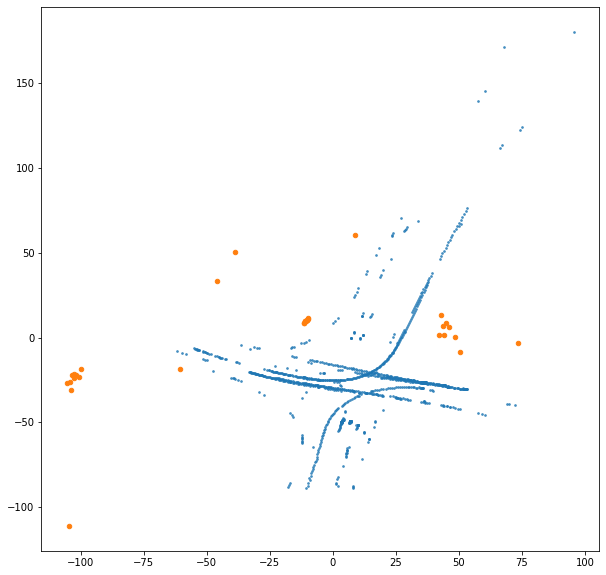

In [21]:
plt.figure(figsize=(10,10))
plt.scatter(X_mean_veh,Y_mean_veh,s = 3,alpha=0.7,label = 'Vehicles')
plt.scatter(X_mean_bck,Y_mean_bck,s = 20,label = 'Dynamic Background')
plt.show()


## Tracking test

In [201]:
traj_path = np.array(os.listdir(r'E:\lidar\pcaps\RawLidarData\FrameSamplingTest\Output File\Output Trajs'))
traj_path = traj_path[np.argsort(np.array([p[:-4] for p in traj_path]).astype('int'))]

In [207]:
trajs = []
for i in range(len(traj_path)):
    traj = pd.read_csv(os.path.join('E:\lidar\pcaps\RawLidarData\FrameSamplingTest\Output File\Output Trajs',traj_path[i]))
    trajs.append(traj.iloc[:-7])

In [15]:
traj_file = pd.read_csv('D:/PCAP_File/2021-12-9-17-0-0/OutputFile/OutputTrajs/Trajctories_0.csv')

In [16]:
trajs = []
for t in traj_file.groupby('ObjectID'):
    trajs.append(t[1])

In [17]:
lengths = [len(t) for t in trajs]

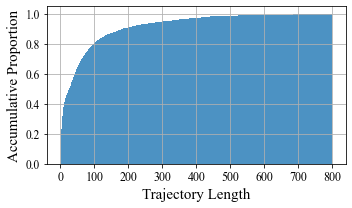

In [326]:
plt.figure(figsize=(5,3))
plt.grid()
plt.hist(lengths,bins = np.arange(800),density=True,cumulative = True, alpha =0.8, )
plt.xlabel('Trajectory Length',fontsize = 15)
plt.ylabel('Accumulative Proportion',fontsize = 15)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 11.5)
# plt.xlim(0,100)
plt.tight_layout()
plt.savefig(r'E:\lidar\20210510 paper proj\traj_len_accum_overall.jpg',dpi = 300)
plt.show()

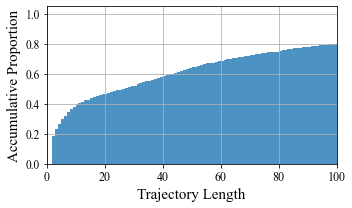

In [325]:
plt.figure(figsize=(5,3))
plt.grid()
plt.hist(lengths,bins = np.arange(800),density=True,cumulative = True, alpha =0.8, )
plt.xlabel('Trajectory Length',fontsize = 15)
plt.ylabel('Accumulative Proportion',fontsize = 15)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 11.5)
plt.xlim(0,100)
plt.tight_layout()
plt.savefig(r'E:\lidar\20210510 paper proj\traj_len_accum_zoomin.jpg',dpi = 300)
plt.show()


In [289]:
initial_coords = np.array([(trajs[i].X_Coord_est.iloc[0],trajs[i].Y_Coord_est.iloc[0]) for i in range(len(trajs))])
end_coords = np.array([(trajs[i].X_Coord_est.iloc[-1],trajs[i].Y_Coord_est.iloc[-1]) for i in range(len(trajs))])

In [284]:
import seaborn as sns

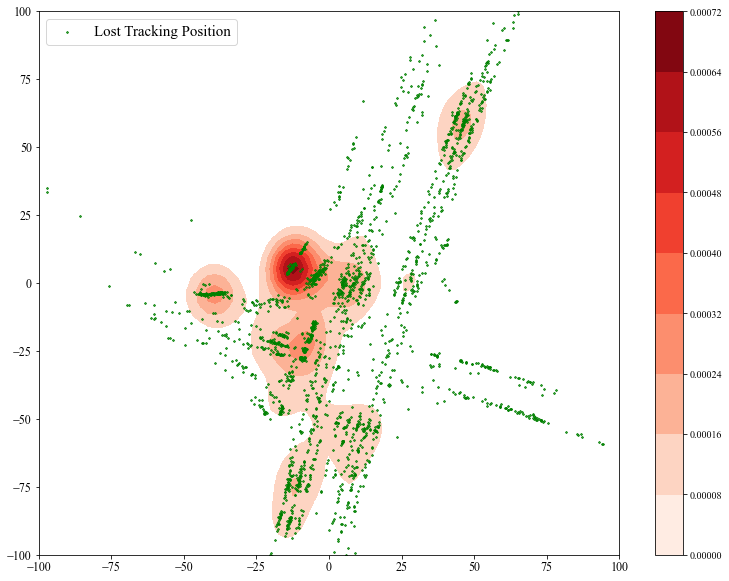

In [324]:
plt.figure(figsize=(13,10))
g = sns.kdeplot(end_coords[:,0],end_coords[:,1],cbar=True,shade =True,cmap = 'Reds',shade_lowest = False)
plt.scatter(end_coords[:,0],end_coords[:,1],marker ='x',s= 3,alpha = 0.8,c = 'g',label = 'Lost Tracking Position')
plt.legend(fontsize = 15)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlim(-100,100)
plt.ylim(-100,100)
plt.savefig(r'E:\lidar\20210510 paper proj\lost_tracking.jpg',dpi = 900)
plt.show()

<Figure size 720x720 with 0 Axes>

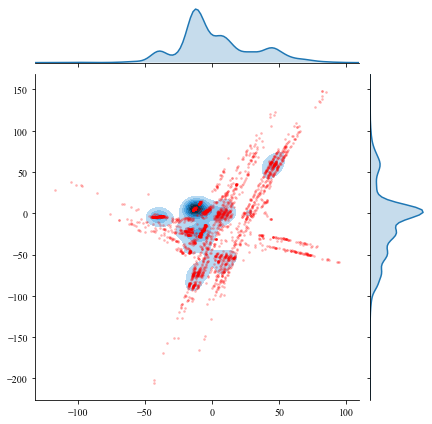

In [314]:
plt.figure(figsize=(10,10))
g = sns.jointplot(x = end_coords[:,0],y = end_coords[:,1] , kind = 'kde',shade_lowest = False)
g.plot_joint(plt.scatter,alpha = 0.2, s = 3,c = 'r')

No handles with labels found to put in legend.


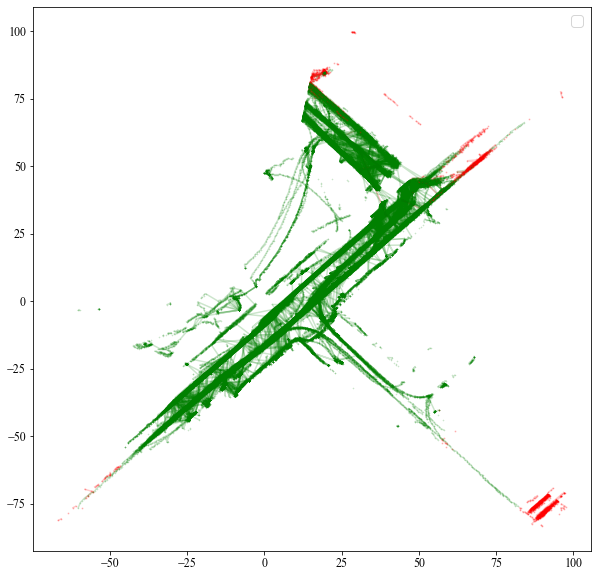

In [18]:
plt.figure(figsize=(10,10))
for i in range(len(trajs)):
    if lengths[i] < 20:
        plt.plot(trajs[i].Coord_X_Mea,trajs[i].Coord_Y_Mea,marker = 'o',markersize = 1,alpha = 0.2,c = 'r')
    else:
         plt.plot(trajs[i].Coord_X_Mea,trajs[i].Coord_Y_Mea,marker = 'x',markersize = 1,alpha = 0.2,c = 'green')
            
# plt.plot(trajs[i].X_Coord_est,trajs[i].Y_Coord_est,marker = 'x',markersize = 1,alpha = 0.2,c = 'green',label = 'Length > 20')
# plt.plot(trajs[i].X_Coord_est,trajs[i].Y_Coord_est,marker = 'o',markersize = 1,alpha = 0.2,c = 'red',label = 'Length < 20')
plt.legend(fontsize = 15)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
# plt.savefig(r'E:\lidar\20210510 paper proj\Tra jsoverview.jpg',dpi = 300)
plt.show()

In [279]:
from dtaidistance import dtw_ndim

In [280]:
xy_coords = []
for i in range(len(trajs)):
    if lengths[i] > 20:
        xy_coords.append(np.array(trajs[i].loc[:,['X_Coord_est','Y_Coord_est']]))

In [282]:
Dis_mat = np.zeros((len(xy_coords),len(xy_coords)))

In [283]:
for i in tqdm(range(Dis_mat.shape[0])):
    for j in range(Dis_mat.shape[1]):
        Dis_mat[i,j] = dtw_ndim.distance(xy_coords[i], xy_coords[j])






  0%|                                                                                         | 0/1435 [00:00<?, ?it/s]




  0%|                                                                              | 1/1435 [00:50<20:10:17, 50.64s/it]




  0%|                                                                             | 2/1435 [04:46<42:16:18, 106.20s/it]




  0%|▏                                                                            | 3/1435 [06:53<44:40:53, 112.33s/it]




  0%|▏                                                                            | 4/1435 [13:07<75:57:39, 191.10s/it]




  0%|▎                                                                            | 5/1435 [16:08<74:37:33, 187.87s/it]




  0%|▎                                                                            | 6/1435 [18:31<69:13:13, 174.38s/it]




  0%|▍                                                                            | 7/1435 [19:17<53:53:06, 135.85s/it]




  1

  8%|█████▉                                                                   | 116/1435 [5:07:07<66:02:32, 180.25s/it]




  8%|█████▉                                                                   | 117/1435 [5:12:43<83:03:03, 226.85s/it]




  8%|██████                                                                   | 118/1435 [5:13:51<65:31:38, 179.12s/it]




  8%|██████                                                                   | 119/1435 [5:18:15<74:52:06, 204.81s/it]




  8%|██████                                                                   | 120/1435 [5:20:04<64:15:53, 175.93s/it]




  8%|██████▏                                                                  | 121/1435 [5:20:52<50:14:45, 137.66s/it]




  9%|██████▏                                                                  | 122/1435 [5:24:37<59:41:39, 163.67s/it]




  9%|██████▎                                                                  | 123/1435 [5:28:48<69:14:54, 190.01s/it]




  9%|███

KeyboardInterrupt: 

In [243]:
s1 = np.array([[0, 0],
               [0, 1],
               [2, 1],
               [0, 1],
               [0, 0]], dtype=np.double)
s2 = np.array([[0, 0],
               [2, 1],
               [0, 1],
               [0, .5],
               [0, 0]], dtype=np.double)
d = dtw_ndim.distance(s1, s2)

In [244]:
d

1.118033988749895